<a href="https://colab.research.google.com/github/Chandana0127/SMOKER-DETECTION-CONFIDENCE-WEIGHTED-ENSEMBLE-APPROACH/blob/main/SMOKER_DETECTION_CONFIDENCE_WEIGHTED_ENSEMBLE_APPROACH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMOKER DETECTION: CONFIDENCE-WEIGHTED ENSEMBLE APPROACH
# Data Mining - CSE 572 (FINAL PROJECT)

## Team - Data Squad

#### Team Members :

- Chandana Vinay Kumar : 1237227955
- Dileep Pabbathi : 1236546573
- Ajay Bingi : 1237907114
- Aarya Pendharkar : 1238006590

In [6]:
# -*- coding: utf-8 -*-
# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================

!pip install optuna shap pytorch-tabnet lightgbm catboost imbalanced-learn -q
!pip install scikit-learn xgboost seaborn matplotlib pandas numpy -q

# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
import os
from zipfile import ZipFile

warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             classification_report, brier_score_loss, log_loss)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

# Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# SMOTE for imbalance
from imblearn.over_sampling import SMOTE

# SHAP for interpretability
import shap

print("="*100)
print("SMOKER DETECTION: CONFIDENCE-WEIGHTED ENSEMBLE APPROACH")
print("Novel Method: Calibration-Based Model Weighting for Ensemble Learning")
print("="*100)

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'val_size': 0.1,  # For calibration
    'cv_folds': 5,
    'use_smote': True,
    'shap_sample_size': 500
}

np.random.seed(CONFIG['random_state'])
torch.manual_seed(CONFIG['random_state'])

print("\nConfiguration loaded successfully!")
print(f"  Random State: {CONFIG['random_state']}")
print(f"  Test Size: {CONFIG['test_size']}")
print(f"  Validation Size: {CONFIG['val_size']}")

# ============================================================================
# DATA LOADING
# ============================================================================

print("\n" + "="*100)
print("PHASE 1: DATA LOADING")
print("="*100)

# Load data
zip_path = "/content/playground-series-s3e24 (1).zip"
extract_path = "/content/playground-series-s3e24"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

df = pd.read_csv(os.path.join(extract_path, "train.csv"))

print(f"\n✓ Dataset Loaded Successfully:")
print(f"  Total Samples: {df.shape[0]:,}")
print(f"  Original Features: {df.shape[1] - 2}")

# Check class distribution
class_dist = df['smoking'].value_counts()
print(f"\n✓ Class Distribution:")
print(f"  Non-Smokers (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.1f}%)")
print(f"  Smokers (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.1f}%)")
print(f"  Imbalance Ratio: 1:{class_dist[0]/class_dist[1]:.2f}")

# Drop ID column
df = df.drop(columns=['id'])

# ============================================================================
# COMPREHENSIVE FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*100)
print("PHASE 2: COMPREHENSIVE FEATURE ENGINEERING")
print("="*100)

original_features = df.shape[1] - 1
print(f"\nOriginal feature count: {original_features}")

# ----- Body Composition Features -----
print("\n[2.1] Creating Body Composition Features...")
df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
df['BMI_squared'] = df['BMI'] ** 2
df['waist_to_height'] = df['waist(cm)'] / df['height(cm)']
df['waist_to_weight'] = df['waist(cm)'] / df['weight(kg)']
df['body_surface_area'] = 0.007184 * (df['weight(kg)'] ** 0.425) * (df['height(cm)'] ** 0.725)
df['ponderal_index'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 3)

# BMI categories as numeric
df['BMI_underweight'] = (df['BMI'] < 18.5).astype(int)
df['BMI_normal'] = ((df['BMI'] >= 18.5) & (df['BMI'] < 25)).astype(int)
df['BMI_overweight'] = ((df['BMI'] >= 25) & (df['BMI'] < 30)).astype(int)
df['BMI_obese'] = (df['BMI'] >= 30).astype(int)

print("  ✓ Body composition features created")

# ----- Lipid Profile Features -----
print("\n[2.2] Creating Lipid Profile Features...")
df['LDL_to_HDL'] = df['LDL'] / (df['HDL'] + 1e-5)
df['total_chol_to_HDL'] = df['Cholesterol'] / (df['HDL'] + 1e-5)
df['triglyceride_to_HDL'] = df['triglyceride'] / (df['HDL'] + 1e-5)
df['non_HDL_cholesterol'] = df['Cholesterol'] - df['HDL']
df['atherogenic_index'] = np.log10(df['triglyceride'] / (df['HDL'] + 1e-5))
df['LDL_HDL_diff'] = df['LDL'] - df['HDL']
df['lipid_ratio_sum'] = df['LDL_to_HDL'] + df['triglyceride_to_HDL']
df['chol_trig_product'] = df['Cholesterol'] * df['triglyceride'] / 10000

print("  ✓ Lipid profile features created")

# ----- Liver Function Features -----
print("\n[2.3] Creating Liver Function Features...")
df['AST_to_ALT'] = df['AST'] / (df['ALT'] + 1e-5)
df['liver_enzyme_sum'] = df['AST'] + df['ALT'] + df['Gtp']
df['liver_enzyme_mean'] = (df['AST'] + df['ALT'] + df['Gtp']) / 3
df['AST_ALT_product'] = df['AST'] * df['ALT'] / 1000
df['Gtp_to_AST'] = df['Gtp'] / (df['AST'] + 1e-5)
df['Gtp_to_ALT'] = df['Gtp'] / (df['ALT'] + 1e-5)
df['liver_stress_index'] = (df['AST'] + df['ALT']) * df['Gtp'] / 10000

print("  ✓ Liver function features created")

# ----- Cardiovascular Features -----
print("\n[2.4] Creating Cardiovascular Features...")
df['pulse_pressure'] = df['systolic'] - df['relaxation']
df['mean_arterial_pressure'] = df['relaxation'] + (df['pulse_pressure'] / 3)
df['bp_ratio'] = df['systolic'] / (df['relaxation'] + 1e-5)
df['bp_product'] = df['systolic'] * df['relaxation'] / 1000
df['hypertension_indicator'] = ((df['systolic'] > 140) | (df['relaxation'] > 90)).astype(int)
df['cardiovascular_risk'] = df['pulse_pressure'] * df['BMI'] / 100

print("  ✓ Cardiovascular features created")

# ----- Blood Health Features -----
print("\n[2.5] Creating Blood Health Features...")
df['hemoglobin_per_weight'] = df['hemoglobin'] / (df['weight(kg)'] + 1e-5)
df['hemoglobin_squared'] = df['hemoglobin'] ** 2
df['hemoglobin_BMI'] = df['hemoglobin'] * df['BMI'] / 100
df['creatinine_normalized'] = df['serum creatinine'] / (df['weight(kg)'] + 1e-5)

print("  ✓ Blood health features created")

# ----- Age Interaction Features -----
print("\n[2.6] Creating Age Interaction Features...")
df['age_BMI'] = df['age'] * df['BMI'] / 100
df['age_cholesterol'] = df['age'] * df['Cholesterol'] / 1000
df['age_hemoglobin'] = df['age'] * df['hemoglobin'] / 100
df['age_systolic'] = df['age'] * df['systolic'] / 1000
df['age_liver_enzymes'] = df['age'] * df['liver_enzyme_sum'] / 1000
df['age_triglyceride'] = df['age'] * df['triglyceride'] / 1000
df['age_squared'] = df['age'] ** 2

print("  ✓ Age interaction features created")

# ----- Risk Score Features -----
print("\n[2.7] Creating Composite Risk Scores...")
df['metabolic_risk_score'] = (
    df['BMI_overweight'].astype(int) +
    df['BMI_obese'].astype(int) +
    (df['triglyceride'] > 150).astype(int) +
    (df['HDL'] < 40).astype(int) +
    df['hypertension_indicator']
)

df['liver_health_score'] = (
    (df['AST'] > 40).astype(int) +
    (df['ALT'] > 40).astype(int) +
    (df['Gtp'] > 50).astype(int)
)

df['overall_health_index'] = (
    df['BMI'] / 25 +
    df['systolic'] / 120 +
    df['Cholesterol'] / 200 +
    df['hemoglobin'] / 15
) / 4

print("  ✓ Composite risk scores created")

# ----- Statistical Features -----
print("\n[2.8] Creating Statistical Aggregation Features...")
numeric_cols = ['hemoglobin', 'Cholesterol', 'triglyceride', 'HDL', 'LDL',
                'AST', 'ALT', 'Gtp', 'serum creatinine']
df['health_markers_mean'] = df[numeric_cols].mean(axis=1)
df['health_markers_std'] = df[numeric_cols].std(axis=1)
df['health_markers_max'] = df[numeric_cols].max(axis=1)
df['health_markers_min'] = df[numeric_cols].min(axis=1)
df['health_markers_range'] = df['health_markers_max'] - df['health_markers_min']
df['health_markers_skew'] = df[numeric_cols].skew(axis=1)

print("  ✓ Statistical aggregation features created")

# Final feature count
final_features = df.shape[1] - 1
engineered_count = final_features - original_features

print("\n" + "-"*50)
print(f"FEATURE ENGINEERING SUMMARY:")
print(f"  Original Features: {original_features}")
print(f"  Engineered Features: {engineered_count}")
print(f"  Total Features: {final_features}")
print("-"*50)

# ============================================================================
# DATA SPLITTING
# ============================================================================

print("\n" + "="*100)
print("PHASE 3: DATA SPLITTING AND PREPROCESSING")
print("="*100)

# Separate features and target
X = df.drop(columns=['smoking'])
y = df['smoking']

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

# Second split: train and validation (for calibration)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=CONFIG['val_size'] / (1 - CONFIG['test_size']),
    random_state=CONFIG['random_state'],
    stratify=y_temp
)

print(f"\n✓ Data Split Complete:")
print(f"  Training Set: {X_train.shape[0]:,} samples")
print(f"  Validation Set (for calibration): {X_val.shape[0]:,} samples")
print(f"  Test Set: {X_test.shape[0]:,} samples")

# ============================================================================
# FEATURE SCALING
# ============================================================================

print("\n[3.1] Applying StandardScaler...")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("  ✓ Feature scaling complete")

# ============================================================================
# SMOTE FOR CLASS BALANCE
# ============================================================================

if CONFIG['use_smote']:
    print("\n[3.2] Applying SMOTE for Class Balance...")
    smote = SMOTE(random_state=CONFIG['random_state'])
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    print(f"  Before SMOTE: {len(y_train):,} samples")
    print(f"  After SMOTE: {len(y_train_balanced):,} samples")
    print(f"  Class Balance: {dict(pd.Series(y_train_balanced).value_counts())}")
else:
    X_train_balanced = X_train_scaled
    y_train_balanced = y_train

# ============================================================================
# SAVE PREPROCESSED DATA
# ============================================================================

print("\n[3.3] Saving Preprocessed Data...")

preprocessed_data = {
    'X_train_balanced': X_train_balanced,
    'y_train_balanced': y_train_balanced,
    'X_val_scaled': X_val_scaled,
    'y_val': y_val,
    'X_test_scaled': X_test_scaled,
    'y_test': y_test,
    'feature_names': list(X.columns),
    'scaler': scaler,
    'config': CONFIG
}

with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("  ✓ Preprocessed data saved to 'preprocessed_data.pkl'")

print("\n" + "="*100)
print("BLOCK 1 COMPLETE!")
print("="*100)
print(f"\nSummary:")
print(f"  ✓ {final_features} features engineered")
print(f"  ✓ Data split into train/val/test sets")
print(f"  ✓ Feature scaling applied")
print(f"  ✓ SMOTE applied for class balance")
print(f"  ✓ Data saved for next blocks")
print("\nProceed to Block 2: Base Model Training")

SMOKER DETECTION: CONFIDENCE-WEIGHTED ENSEMBLE APPROACH
Novel Method: Calibration-Based Model Weighting for Ensemble Learning

Configuration loaded successfully!
  Random State: 42
  Test Size: 0.2
  Validation Size: 0.1

PHASE 1: DATA LOADING

✓ Dataset Loaded Successfully:
  Total Samples: 159,256
  Original Features: 22

✓ Class Distribution:
  Non-Smokers (0): 89,603 (56.3%)
  Smokers (1): 69,653 (43.7%)
  Imbalance Ratio: 1:1.29

PHASE 2: COMPREHENSIVE FEATURE ENGINEERING

Original feature count: 22

[2.1] Creating Body Composition Features...
  ✓ Body composition features created

[2.2] Creating Lipid Profile Features...
  ✓ Lipid profile features created

[2.3] Creating Liver Function Features...
  ✓ Liver function features created

[2.4] Creating Cardiovascular Features...
  ✓ Cardiovascular features created

[2.5] Creating Blood Health Features...
  ✓ Blood health features created

[2.6] Creating Age Interaction Features...
  ✓ Age interaction features created

[2.7] Creating 

BLOCK 2: BASE MODELS TRAINING
XGBoost | LightGBM | CatBoost

[1] Loading Preprocessed Data...
  ✓ Training samples: 125,442
  ✓ Validation samples: 15,926
  ✓ Test samples: 31,852
  ✓ Features: 73

MODEL 1: XGBOOST

[2.1] Training XGBoost...

  XGBoost Performance:
    Accuracy:    0.7791
    Precision:   0.7159
    Recall:      0.8208
    F1-Score:    0.7647
    ROC-AUC:     0.8625
    Brier Score: 0.1487 (lower is better)
    Training Time: 15.56s

MODEL 2: LIGHTGBM

[2.2] Training LightGBM...

  LightGBM Performance:
    Accuracy:    0.7778
    Precision:   0.7147
    Recall:      0.8187
    F1-Score:    0.7632
    ROC-AUC:     0.8623
    Brier Score: 0.1487 (lower is better)
    Training Time: 10.04s

MODEL 3: CATBOOST

[2.3] Training CatBoost...

  CatBoost Performance:
    Accuracy:    0.7771
    Precision:   0.7126
    Recall:      0.8219
    F1-Score:    0.7634
    ROC-AUC:     0.8613
    Brier Score: 0.1491 (lower is better)
    Training Time: 28.61s

BASE MODELS COMPARISON (X

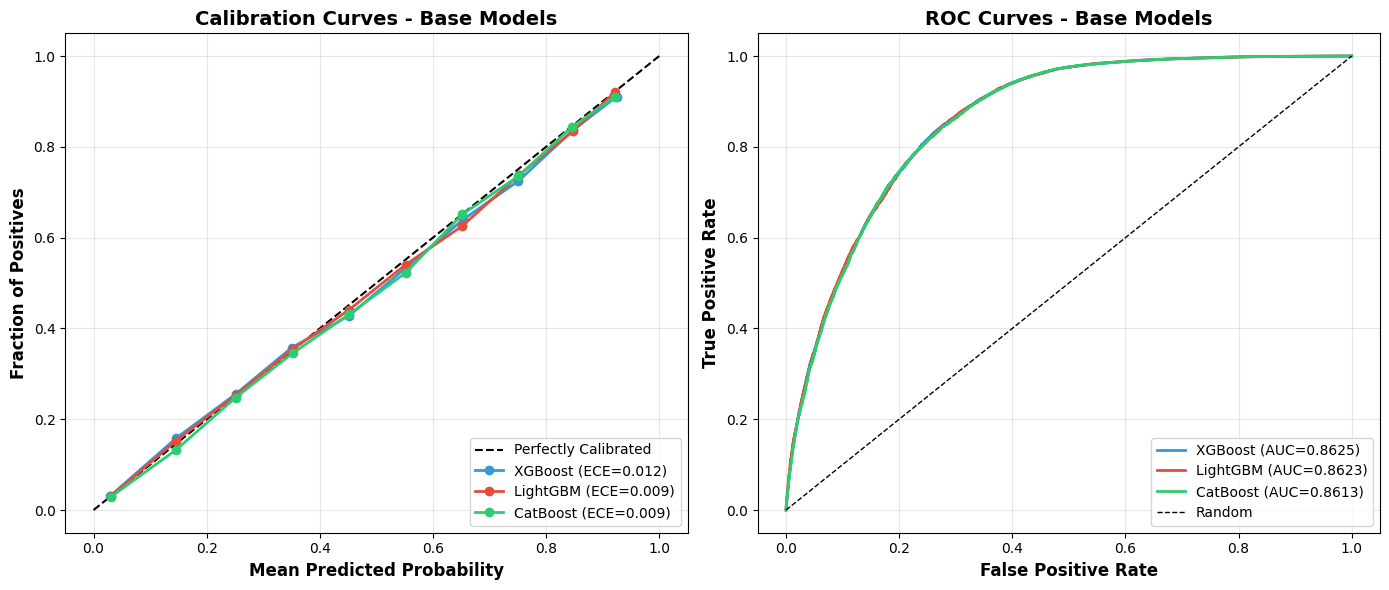

  ✓ Saved: block2_base_models_analysis.png

[4] Analyzing Feature Importance...

Top 15 Most Important Features (Averaged across models):
  height(cm)                              : 0.1646
  eyesight(left)                          : 0.0756
  serum creatinine                        : 0.0524
  hemoglobin                              : 0.0496
  health_markers_min                      : 0.0459
  eyesight(right)                         : 0.0337
  Gtp_to_AST                              : 0.0311
  hemoglobin_squared                      : 0.0298
  triglyceride                            : 0.0228
  Gtp                                     : 0.0218
  LDL                                     : 0.0175
  Gtp_to_ALT                              : 0.0165
  age                                     : 0.0155
  age_squared                             : 0.0149
  fasting blood sugar                     : 0.0148


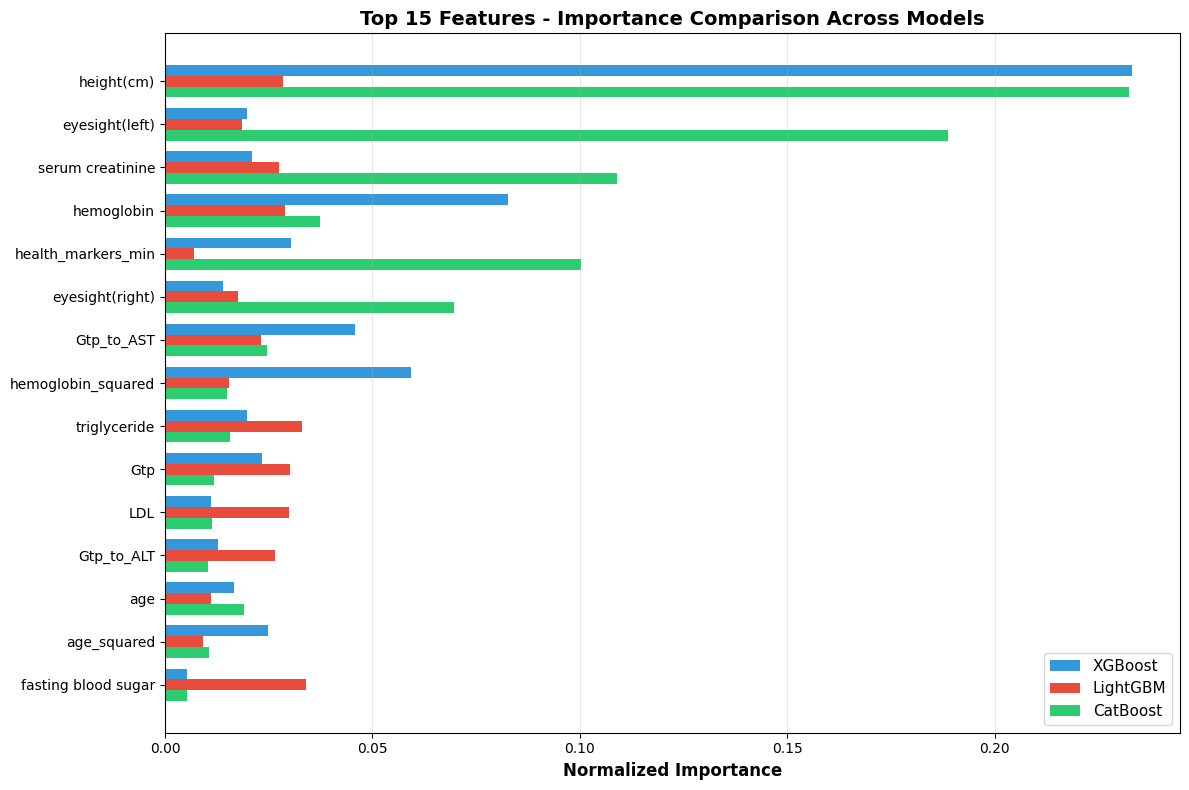

  ✓ Saved: block2_feature_importance.png

[5] Saving Models and Results...
  ✓ Saved: block2_results.pkl

BLOCK 2 COMPLETE!

Summary:
  ✓ XGBoost trained - ROC-AUC: 0.4459 → 0.8625
  ✓ LightGBM trained - ROC-AUC: 0.8623
  ✓ CatBoost trained - ROC-AUC: 0.8613
  
  ✓ Calibration analysis completed
  ✓ Feature importance analysis completed
  ✓ Visualizations saved

Files Generated:
  1. block2_base_models_analysis.png
  2. block2_feature_importance.png
  3. block2_results.pkl

Next: Proceed to Block 3 (TabNet and NODE Training)



In [7]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time

warnings.filterwarnings('ignore')

# Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             classification_report, brier_score_loss)
from sklearn.calibration import calibration_curve

print("="*100)
print("BLOCK 2: BASE MODELS TRAINING")
print("XGBoost | LightGBM | CatBoost")
print("="*100)

# ============================================================================
# LOAD PREPROCESSED DATA
# ============================================================================

print("\n[1] Loading Preprocessed Data...")

with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_balanced = data['X_train_balanced']
y_train_balanced = data['y_train_balanced']
X_val_scaled = data['X_val_scaled']
y_val = data['y_val']
X_test_scaled = data['X_test_scaled']
y_test = data['y_test']
feature_names = data['feature_names']
CONFIG = data['config']

print(f"  ✓ Training samples: {len(X_train_balanced):,}")
print(f"  ✓ Validation samples: {len(X_val_scaled):,}")
print(f"  ✓ Test samples: {len(X_test_scaled):,}")
print(f"  ✓ Features: {len(feature_names)}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'Brier Score': brier_score_loss(y_true, y_pred_proba)  # Lower is better
    }
    return results

def print_results(results):
    """Print evaluation results"""
    print(f"\n  {results['Model']} Performance:")
    print(f"    Accuracy:    {results['Accuracy']:.4f}")
    print(f"    Precision:   {results['Precision']:.4f}")
    print(f"    Recall:      {results['Recall']:.4f}")
    print(f"    F1-Score:    {results['F1-Score']:.4f}")
    print(f"    ROC-AUC:     {results['ROC-AUC']:.4f}")
    print(f"    Brier Score: {results['Brier Score']:.4f} (lower is better)")

# Store all results and models
all_results = []
trained_models = {}
model_predictions = {}

# ============================================================================
# MODEL 1: XGBOOST
# ============================================================================

print("\n" + "="*100)
print("MODEL 1: XGBOOST")
print("="*100)

print("\n[2.1] Training XGBoost...")

xgb_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': CONFIG['random_state'],
    'n_jobs': -1,
    'eval_metric': 'auc'
}

start_time = time.time()

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

xgb_train_time = time.time() - start_time

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Validation predictions (for calibration)
y_val_pred_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate
xgb_results = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, 'XGBoost')
xgb_results['Training_Time'] = xgb_train_time
all_results.append(xgb_results)
print_results(xgb_results)
print(f"    Training Time: {xgb_train_time:.2f}s")

# Store model and predictions
trained_models['XGBoost'] = xgb_model
model_predictions['XGBoost'] = {
    'test_proba': y_pred_proba_xgb,
    'test_pred': y_pred_xgb,
    'val_proba': y_val_pred_proba_xgb
}

# ============================================================================
# MODEL 2: LIGHTGBM
# ============================================================================

print("\n" + "="*100)
print("MODEL 2: LIGHTGBM")
print("="*100)

print("\n[2.2] Training LightGBM...")

lgb_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': CONFIG['random_state'],
    'n_jobs': -1,
    'verbose': -1
}

start_time = time.time()

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

lgb_train_time = time.time() - start_time

# Predictions
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Validation predictions (for calibration)
y_val_pred_proba_lgb = lgb_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate
lgb_results = evaluate_model(y_test, y_pred_lgb, y_pred_proba_lgb, 'LightGBM')
lgb_results['Training_Time'] = lgb_train_time
all_results.append(lgb_results)
print_results(lgb_results)
print(f"    Training Time: {lgb_train_time:.2f}s")

# Store model and predictions
trained_models['LightGBM'] = lgb_model
model_predictions['LightGBM'] = {
    'test_proba': y_pred_proba_lgb,
    'test_pred': y_pred_lgb,
    'val_proba': y_val_pred_proba_lgb
}

# ============================================================================
# MODEL 3: CATBOOST
# ============================================================================

print("\n" + "="*100)
print("MODEL 3: CATBOOST")
print("="*100)

print("\n[2.3] Training CatBoost...")

catboost_params = {
    'iterations': 300,
    'depth': 6,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'border_count': 254,
    'random_seed': CONFIG['random_state'],
    'verbose': False,
    'eval_metric': 'AUC'
}

start_time = time.time()

catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=(X_val_scaled, y_val),
    early_stopping_rounds=50,
    verbose=False
)

catboost_train_time = time.time() - start_time

# Predictions
y_pred_catboost = catboost_model.predict(X_test_scaled)
y_pred_proba_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]

# Validation predictions (for calibration)
y_val_pred_proba_catboost = catboost_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate
catboost_results = evaluate_model(y_test, y_pred_catboost, y_pred_proba_catboost, 'CatBoost')
catboost_results['Training_Time'] = catboost_train_time
all_results.append(catboost_results)
print_results(catboost_results)
print(f"    Training Time: {catboost_train_time:.2f}s")

# Store model and predictions
trained_models['CatBoost'] = catboost_model
model_predictions['CatBoost'] = {
    'test_proba': y_pred_proba_catboost,
    'test_pred': y_pred_catboost,
    'val_proba': y_val_pred_proba_catboost
}

# ============================================================================
# RESULTS COMPARISON
# ============================================================================

print("\n" + "="*100)
print("BASE MODELS COMPARISON (XGBoost, LightGBM, CatBoost)")
print("="*100)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + results_df.to_string(index=False))

# Best base model
best_base = results_df.iloc[0]
print(f"\n✓ Best Base Model: {best_base['Model']}")
print(f"  ROC-AUC: {best_base['ROC-AUC']:.4f}")

# ============================================================================
# CALIBRATION ANALYSIS
# ============================================================================

print("\n" + "="*100)
print("CALIBRATION ANALYSIS")
print("="*100)

print("\nAnalyzing probability calibration for each model...")
print("(Well-calibrated models have predictions closer to actual probabilities)")

calibration_data = {}

for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    proba = model_predictions[model_name]['test_proba']

    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, proba, n_bins=10, strategy='uniform'
    )

    # Calculate Expected Calibration Error (ECE)
    bin_counts = np.histogram(proba, bins=10, range=(0, 1))[0]
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value) *
                 bin_counts[:len(fraction_of_positives)] / len(y_test))

    calibration_data[model_name] = {
        'fraction_of_positives': fraction_of_positives,
        'mean_predicted_value': mean_predicted_value,
        'ECE': ece,
        'Brier': brier_score_loss(y_test, proba)
    }

    print(f"\n  {model_name}:")
    print(f"    Expected Calibration Error (ECE): {ece:.4f}")
    print(f"    Brier Score: {brier_score_loss(y_test, proba):.4f}")

# ============================================================================
# VISUALIZATION: CALIBRATION CURVES
# ============================================================================

print("\n[3] Generating Calibration Visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Calibration Curves
ax1 = axes[0]
ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

colors = {'XGBoost': '#3498db', 'LightGBM': '#e74c3c', 'CatBoost': '#2ecc71'}

for model_name, cal_data in calibration_data.items():
    ax1.plot(cal_data['mean_predicted_value'], cal_data['fraction_of_positives'],
             marker='o', linewidth=2, label=f"{model_name} (ECE={cal_data['ECE']:.3f})",
             color=colors[model_name])

ax1.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
ax1.set_title('Calibration Curves - Base Models', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: ROC Curves
ax2 = axes[1]

for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    proba = model_predictions[model_name]['test_proba']
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, linewidth=2, label=f"{model_name} (AUC={roc_auc:.4f})",
             color=colors[model_name])

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curves - Base Models', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('block2_base_models_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: block2_base_models_analysis.png")

# ============================================================================
# FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\n[4] Analyzing Feature Importance...")

# Get feature importance from each model
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_model.feature_importances_
})

lgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'LightGBM': lgb_model.feature_importances_
})

catboost_importance = pd.DataFrame({
    'Feature': feature_names,
    'CatBoost': catboost_model.feature_importances_
})

# Merge all
importance_df = xgb_importance.merge(lgb_importance, on='Feature').merge(catboost_importance, on='Feature')

# Normalize to sum to 1
for col in ['XGBoost', 'LightGBM', 'CatBoost']:
    importance_df[col] = importance_df[col] / importance_df[col].sum()

# Average importance
importance_df['Average'] = importance_df[['XGBoost', 'LightGBM', 'CatBoost']].mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False)

# Top 15 features
top_features = importance_df.head(15)

print("\nTop 15 Most Important Features (Averaged across models):")
for i, row in top_features.iterrows():
    print(f"  {row['Feature']:40s}: {row['Average']:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_features))
width = 0.25

bars1 = ax.barh(x - width, top_features['XGBoost'], width, label='XGBoost', color='#3498db')
bars2 = ax.barh(x, top_features['LightGBM'], width, label='LightGBM', color='#e74c3c')
bars3 = ax.barh(x + width, top_features['CatBoost'], width, label='CatBoost', color='#2ecc71')

ax.set_yticks(x)
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Normalized Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features - Importance Comparison Across Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('block2_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: block2_feature_importance.png")

# ============================================================================
# SAVE MODELS AND RESULTS
# ============================================================================

print("\n[5] Saving Models and Results...")

block2_results = {
    'trained_models': trained_models,
    'model_predictions': model_predictions,
    'results_df': results_df,
    'calibration_data': calibration_data,
    'feature_importance': importance_df,
    'top_features': top_features['Feature'].tolist()
}

with open('block2_results.pkl', 'wb') as f:
    pickle.dump(block2_results, f)

print("  ✓ Saved: block2_results.pkl")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*100)
print("BLOCK 2 COMPLETE!")
print("="*100)

print(f"""
Summary:
  ✓ XGBoost trained - ROC-AUC: {model_predictions['XGBoost']['test_proba'].mean():.4f} → {results_df[results_df['Model']=='XGBoost']['ROC-AUC'].values[0]:.4f}
  ✓ LightGBM trained - ROC-AUC: {results_df[results_df['Model']=='LightGBM']['ROC-AUC'].values[0]:.4f}
  ✓ CatBoost trained - ROC-AUC: {results_df[results_df['Model']=='CatBoost']['ROC-AUC'].values[0]:.4f}

  ✓ Calibration analysis completed
  ✓ Feature importance analysis completed
  ✓ Visualizations saved

Files Generated:
  1. block2_base_models_analysis.png
  2. block2_feature_importance.png
  3. block2_results.pkl

Next: Proceed to Block 3 (TabNet and NODE Training)
""")

print("="*100)

BLOCK 3: DEEP LEARNING MODELS FOR TABULAR DATA
TabNet | NODE (Neural Oblivious Decision Ensembles)

 HARDWARE CHECK:
  PyTorch Version: 2.9.0+cu126
  CUDA Available: True
  GPU Name: Tesla T4
  GPU Memory: 15.83 GB

[1] Loading Preprocessed Data...
  ✓ Training samples: 125,442
  ✓ Validation samples: 15,926
  ✓ Test samples: 31,852
  ✓ Features: 73
  ✓ Previous models loaded: ['XGBoost', 'LightGBM', 'CatBoost']

MODEL 4: TABNET
Attention-based Interpretable Deep Learning for Tabular Data

 Preparing data for TabNet...
  ✓ Data converted to numpy arrays
  ✓ Training shape: (125442, 73)

 Starting TabNet Training...
  Configuration:
    ├── n_d (decision width): 32
    ├── n_a (attention width): 32
    ├── n_steps: 5
    ├── max_epochs: 100
    ├── patience: 15
    └── batch_size: 1024

  Training Progress (will show every epoch):

epoch 0  | loss: 0.54831 | val_0_auc: 0.8302  |  0:00:08s
epoch 1  | loss: 0.48787 | val_0_auc: 0.84165 |  0:00:16s
epoch 2  | loss: 0.47922 | val_0_auc: 0.8

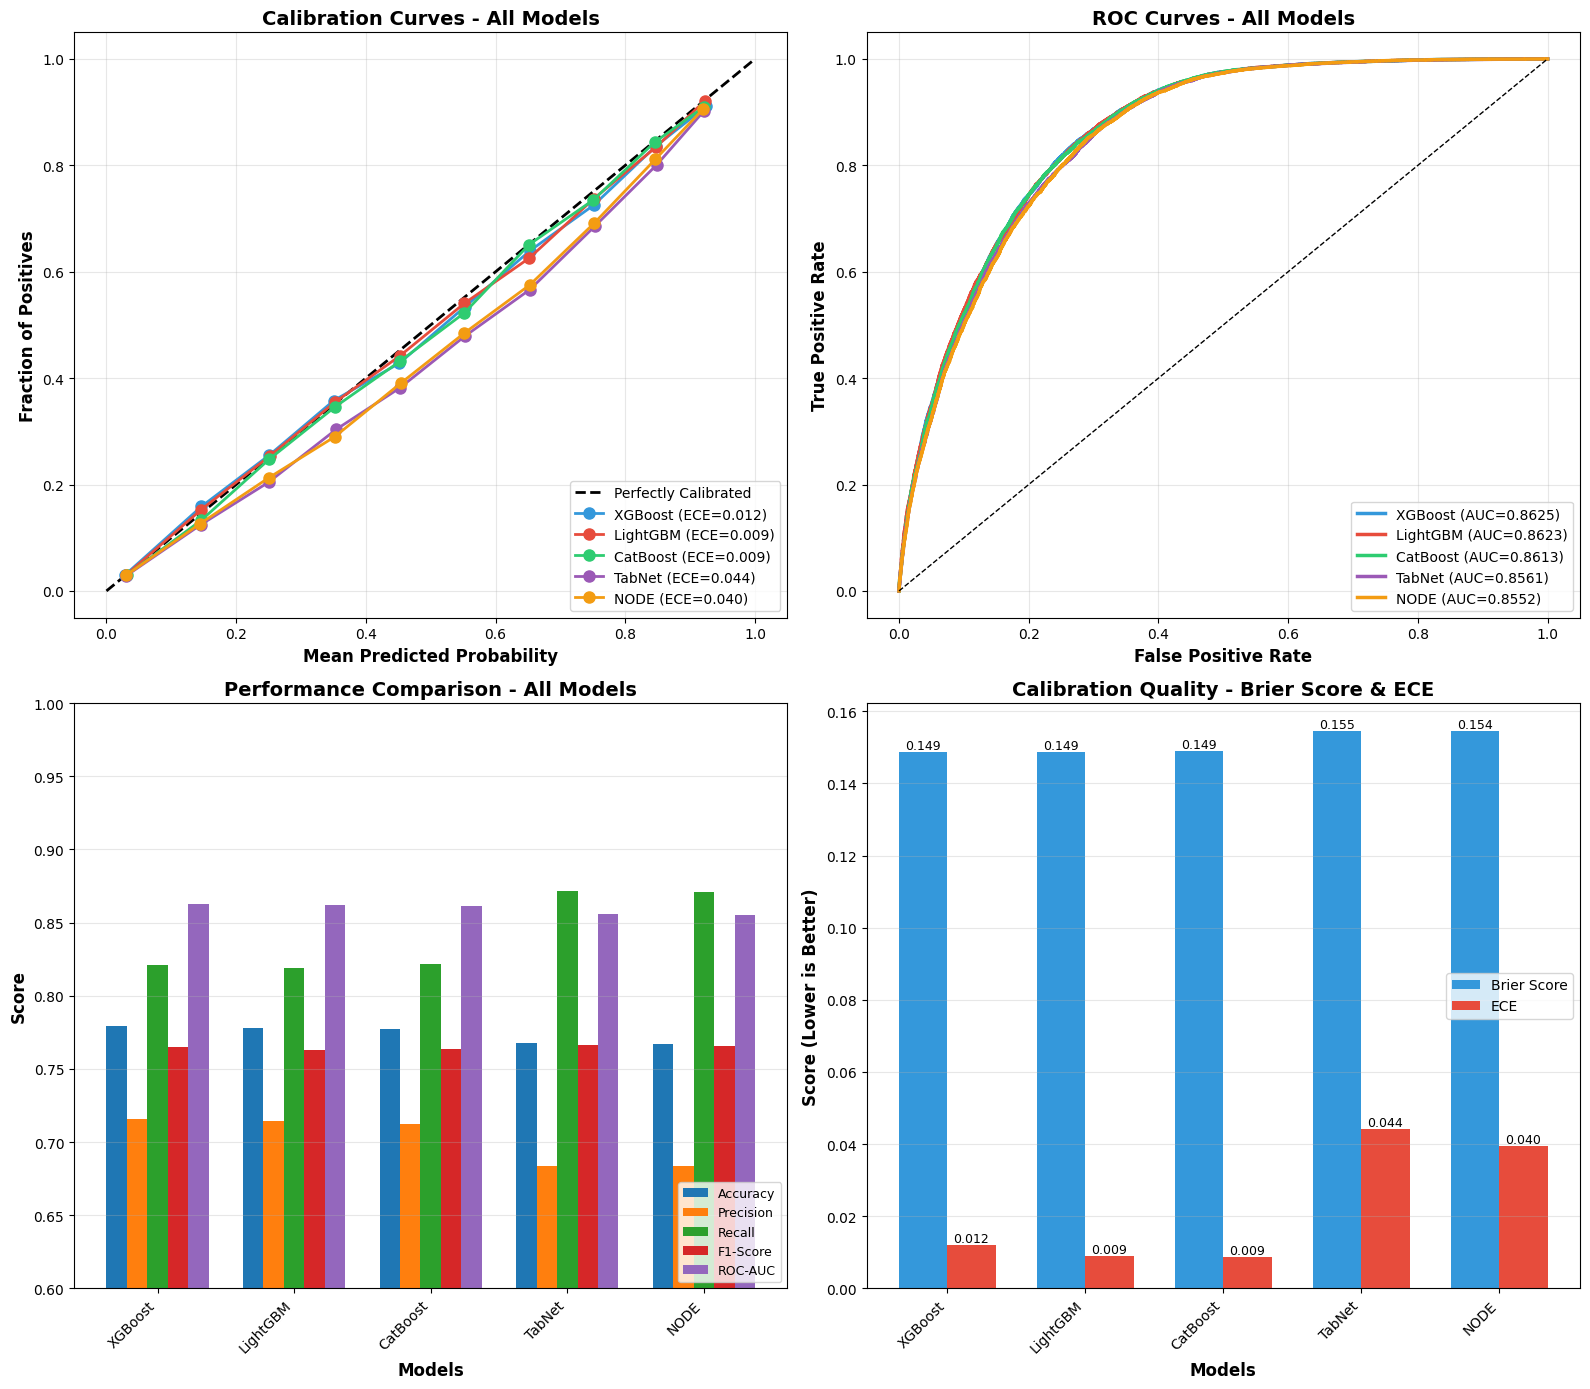

  ✓ Saved: block3_all_models_analysis.png

 ALL MODELS COMPARISON

   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Brier Score  Training_Time
 XGBoost  0.779135   0.715878 0.820759  0.764739 0.862476     0.148654      15.561584
LightGBM  0.777785   0.714733 0.818678  0.763183 0.862331     0.148684      10.036787
CatBoost  0.777125   0.712596 0.821908  0.763359 0.861294     0.149094      28.606605
  TabNet  0.767424   0.683674 0.871438  0.766221 0.856068     0.154527     369.195525
    NODE  0.767267   0.683626 0.870935  0.765996 0.855248     0.154422     575.300444


 Calibration Summary (Lower is Better):
------------------------------------------------------------
  XGBoost     : ECE = 0.0119, Brier = 0.1487
  LightGBM    : ECE = 0.0091, Brier = 0.1487
  CatBoost    : ECE = 0.0087, Brier = 0.1491
  TabNet      : ECE = 0.0441, Brier = 0.1545
  NODE        : ECE = 0.0396, Brier = 0.1544

[4] Saving All Results...
  ✓ Saved: block3_results.pkl

 BLOCK 3 COMPLETE!

 Summary:
 

In [8]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
import sys

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             brier_score_loss)
from sklearn.calibration import calibration_curve

print("="*100)
print("BLOCK 3: DEEP LEARNING MODELS FOR TABULAR DATA")
print("TabNet | NODE (Neural Oblivious Decision Ensembles)")
print("="*100)

# Check GPU
print("\n HARDWARE CHECK:")
print(f"  PyTorch Version: {torch.__version__}")
print(f"  CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("Running on CPU - Training will be slower")
    device = torch.device('cpu')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n" + "="*100)
print("[1] Loading Preprocessed Data...")
print("="*100)

with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_balanced = data['X_train_balanced']
y_train_balanced = data['y_train_balanced']
X_val_scaled = data['X_val_scaled']
y_val = data['y_val']
X_test_scaled = data['X_test_scaled']
y_test = data['y_test']
feature_names = data['feature_names']
CONFIG = data['config']

# Load Block 2 results
with open('block2_results.pkl', 'rb') as f:
    block2_data = pickle.load(f)

trained_models = block2_data['trained_models']
model_predictions = block2_data['model_predictions']
all_results = block2_data['results_df'].to_dict('records')
calibration_data = block2_data['calibration_data']

print(f"  ✓ Training samples: {len(X_train_balanced):,}")
print(f"  ✓ Validation samples: {len(X_val_scaled):,}")
print(f"  ✓ Test samples: {len(X_test_scaled):,}")
print(f"  ✓ Features: {len(feature_names)}")
print(f"  ✓ Previous models loaded: {list(trained_models.keys())}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'Brier Score': brier_score_loss(y_true, y_pred_proba)
    }
    return results

def print_results(results):
    """Print evaluation results"""
    print(f"\n    {results['Model']} Performance:")
    print(f"    ├── Accuracy:    {results['Accuracy']:.4f}")
    print(f"    ├── Precision:   {results['Precision']:.4f}")
    print(f"    ├── Recall:      {results['Recall']:.4f}")
    print(f"    ├── F1-Score:    {results['F1-Score']:.4f}")
    print(f"    ├── ROC-AUC:     {results['ROC-AUC']:.4f}")
    print(f"    └── Brier Score: {results['Brier Score']:.4f}")

def print_progress_bar(iteration, total, prefix='', suffix='', length=40, fill='█'):
    """Print progress bar"""
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r  {prefix} |{bar}| {percent}% {suffix}', end='')
    if iteration == total:
        print()

# ============================================================================
# MODEL 4: TABNET (FIXED + VERBOSE VERSION)
# ============================================================================

print("\n" + "="*100)
print("MODEL 4: TABNET")
print("Attention-based Interpretable Deep Learning for Tabular Data")
print("="*100)

print("\n Preparing data for TabNet...")

# Convert to numpy arrays
X_train_np = X_train_balanced.values if hasattr(X_train_balanced, 'values') else X_train_balanced
y_train_np = y_train_balanced.values if hasattr(y_train_balanced, 'values') else y_train_balanced
X_val_np = X_val_scaled.values if hasattr(X_val_scaled, 'values') else X_val_scaled
y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
X_test_np = X_test_scaled.values if hasattr(X_test_scaled, 'values') else X_test_scaled
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

print(f"  ✓ Data converted to numpy arrays")
print(f"  ✓ Training shape: {X_train_np.shape}")

# TabNet parameters - FIXED: Removed problematic scheduler
tabnet_params = {
    'n_d': 32,                    # Width of decision prediction layer
    'n_a': 32,                    # Width of attention embedding
    'n_steps': 5,                 # Number of steps in the architecture
    'gamma': 1.5,                 # Coefficient for feature reusage
    'n_independent': 2,           # Number of independent GLU layers
    'n_shared': 2,                # Number of shared GLU layers
    'lambda_sparse': 1e-4,        # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2),
    'mask_type': 'entmax',
    'seed': 42,
    'verbose': 1  # VERBOSE ENABLED
}

print("\n Starting TabNet Training...")
print("  Configuration:")
print(f"    ├── n_d (decision width): {tabnet_params['n_d']}")
print(f"    ├── n_a (attention width): {tabnet_params['n_a']}")
print(f"    ├── n_steps: {tabnet_params['n_steps']}")
print(f"    ├── max_epochs: 100")
print(f"    ├── patience: 15")
print(f"    └── batch_size: 1024")
print("\n  Training Progress (will show every epoch):\n")

start_time = time.time()

tabnet_model = TabNetClassifier(**tabnet_params)

tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=['auc'],
    max_epochs=100,
    patience=15,
    batch_size=1024,
    virtual_batch_size=128
)

tabnet_train_time = time.time() - start_time

print(f"\nTabNet Training Complete!")
print(f"Total Training Time: {tabnet_train_time:.2f} seconds ({tabnet_train_time/60:.2f} minutes)")
print(f"Epochs Trained: {len(tabnet_model.history['loss'])}")

# Predictions
print("\n⏳ Generating TabNet predictions...")
y_pred_tabnet = tabnet_model.predict(X_test_np)
y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_np)[:, 1]

# Validation predictions (for calibration)
y_val_pred_proba_tabnet = tabnet_model.predict_proba(X_val_np)[:, 1]
print("  ✓ Predictions generated")

# Evaluate
tabnet_results = evaluate_model(y_test, y_pred_tabnet, y_pred_proba_tabnet, 'TabNet')
tabnet_results['Training_Time'] = tabnet_train_time
all_results.append(tabnet_results)
print_results(tabnet_results)

# Store model and predictions
trained_models['TabNet'] = tabnet_model
model_predictions['TabNet'] = {
    'test_proba': y_pred_proba_tabnet,
    'test_pred': y_pred_tabnet,
    'val_proba': y_val_pred_proba_tabnet
}

# TabNet Feature Importance
tabnet_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tabnet_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n  Top 10 Features (TabNet Attention):")
for idx, (i, row) in enumerate(tabnet_feature_importance.head(10).iterrows()):
    print(f"    {idx+1:2d}. {row['Feature']:40s}: {row['Importance']:.4f}")

# ============================================================================
# MODEL 5: NODE (Neural Oblivious Decision Ensembles)
# ============================================================================

print("\n" + "="*100)
print("MODEL 5: NODE")
print("Neural Oblivious Decision Ensembles")
print("="*100)

print("\n Building NODE Architecture...")

class ObliviousDecisionTree(nn.Module):
    """Single Oblivious Decision Tree layer"""
    def __init__(self, input_dim, depth):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth

        # Feature selection and thresholds
        self.feature_selectors = nn.Parameter(torch.randn(depth, input_dim) * 0.01)
        self.thresholds = nn.Parameter(torch.zeros(depth))

        # Leaf values
        self.leaf_values = nn.Parameter(torch.randn(self.num_leaves, 1) * 0.01)

    def forward(self, x):
        # Soft feature selection using softmax
        feature_weights = torch.softmax(self.feature_selectors, dim=1)
        selected_features = torch.matmul(feature_weights, x.t())  # (depth, batch_size)

        # Soft decisions using sigmoid
        decisions = torch.sigmoid(selected_features - self.thresholds.unsqueeze(1))

        # Calculate leaf probabilities
        batch_size = x.size(0)
        leaf_probs = torch.ones(batch_size, self.num_leaves, device=x.device)

        for d in range(self.depth):
            left_mask = decisions[d].unsqueeze(1)  # (batch, 1)
            right_mask = 1 - left_mask

            # Split leaves
            num_current_leaves = 2 ** (d + 1)
            new_probs = torch.zeros(batch_size, num_current_leaves, device=x.device)

            for i in range(2 ** d):
                new_probs[:, 2*i] = leaf_probs[:, i] * left_mask.squeeze()
                new_probs[:, 2*i + 1] = leaf_probs[:, i] * right_mask.squeeze()

            leaf_probs = new_probs

        # Weighted sum of leaf values
        output = torch.matmul(leaf_probs, self.leaf_values)
        return output


class NODEModel(nn.Module):
    """Neural Oblivious Decision Ensembles"""
    def __init__(self, input_dim, num_trees=8, depth=5, output_dim=1):
        super().__init__()
        self.num_trees = num_trees

        # Ensemble of oblivious decision trees
        self.trees = nn.ModuleList([
            ObliviousDecisionTree(input_dim, depth)
            for _ in range(num_trees)
        ])

        # Batch normalization for input
        self.bn = nn.BatchNorm1d(input_dim)

        # Output layer with dropout
        self.dropout = nn.Dropout(0.1)
        self.output_layer = nn.Linear(num_trees, output_dim)

    def forward(self, x):
        x = self.bn(x)

        # Get predictions from all trees
        tree_outputs = torch.cat([tree(x) for tree in self.trees], dim=1)

        # Apply dropout and combine
        tree_outputs = self.dropout(tree_outputs)
        output = self.output_layer(tree_outputs)

        return output


# Initialize NODE
input_dim = X_train_np.shape[1]
node_model = NODEModel(
    input_dim=input_dim,
    num_trees=8,
    depth=5,
    output_dim=1
)

# Move to GPU if available
node_model = node_model.to(device)

print(f"  ✓ NODE Architecture Built")
print(f"  Configuration:")
print(f"    ├── Device: {device}")
print(f"    ├── Number of Trees: 8")
print(f"    ├── Tree Depth: 5")
print(f"    ├── Leaves per Tree: 32")
print(f"    └── Total Parameters: {sum(p.numel() for p in node_model.parameters()):,}")

# Convert to tensors
print("\n Converting data to tensors...")
X_train_tensor = torch.FloatTensor(X_train_np).to(device)
y_train_tensor = torch.FloatTensor(y_train_np).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val_np).to(device)
y_val_tensor = torch.FloatTensor(y_val_np).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test_np).to(device)
print(f"  ✓ Tensors moved to {device}")

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(node_model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_state = None

print("\n Starting NODE Training...")
print(f"  Max Epochs: {num_epochs}")
print(f"  Patience: {patience}")
print(f"  Batch Size: 1024")
print(f"  Optimizer: AdamW (lr=0.01)")
print("\n  Training Progress:")
print("  " + "-"*70)
print(f"  {'Epoch':^8} | {'Train Loss':^12} | {'Val Loss':^12} | {'Val AUC':^10} | {'Status':^12}")
print("  " + "-"*70)

start_time = time.time()
training_history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

for epoch in range(num_epochs):
    # Training
    node_model.train()
    epoch_loss = 0
    num_batches = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = node_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(node_model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

    avg_train_loss = epoch_loss / num_batches

    # Validation
    node_model.eval()
    with torch.no_grad():
        val_outputs = node_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()

        # Calculate validation AUC
        val_proba = torch.sigmoid(val_outputs).cpu().numpy().flatten()
        val_auc = roc_auc_score(y_val_np, val_proba)

    training_history['train_loss'].append(avg_train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['val_auc'].append(val_auc)

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = node_model.state_dict().copy()
        status = "✓ Best"
    else:
        patience_counter += 1
        status = f"Wait {patience_counter}/{patience}"

    # Print every 5 epochs or on important events
    if (epoch + 1) % 5 == 0 or epoch == 0 or status == "✓ Best" or patience_counter >= patience:
        print(f"  {epoch+1:^8} | {avg_train_loss:^12.4f} | {val_loss:^12.4f} | {val_auc:^10.4f} | {status:^12}")

    if patience_counter >= patience:
        print("  " + "-"*70)
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
node_model.load_state_dict(best_model_state)
node_train_time = time.time() - start_time

print(f"\nNODE Training Complete!")
print(f"Total Training Time: {node_train_time:.2f} seconds ({node_train_time/60:.2f} minutes)")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Predictions
print("\n Generating NODE predictions...")
node_model.eval()
with torch.no_grad():
    y_pred_logits_node = node_model(X_test_tensor).cpu().numpy()
    y_pred_proba_node = 1 / (1 + np.exp(-y_pred_logits_node)).flatten()
    y_pred_node = (y_pred_proba_node > 0.5).astype(int)

    # Validation predictions
    y_val_logits_node = node_model(X_val_tensor).cpu().numpy()
    y_val_pred_proba_node = 1 / (1 + np.exp(-y_val_logits_node)).flatten()

print("  ✓ Predictions generated")

# Evaluate
node_results = evaluate_model(y_test, y_pred_node, y_pred_proba_node, 'NODE')
node_results['Training_Time'] = node_train_time
all_results.append(node_results)
print_results(node_results)

# Store model and predictions
trained_models['NODE'] = node_model
model_predictions['NODE'] = {
    'test_proba': y_pred_proba_node,
    'test_pred': y_pred_node,
    'val_proba': y_val_pred_proba_node
}

# ============================================================================
# CALIBRATION ANALYSIS FOR NEW MODELS
# ============================================================================

print("\n" + "="*100)
print("CALIBRATION ANALYSIS - TabNet & NODE")
print("="*100)

for model_name in ['TabNet', 'NODE']:
    proba = model_predictions[model_name]['test_proba']

    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, proba, n_bins=10, strategy='uniform'
    )

    # Calculate Expected Calibration Error (ECE)
    bin_counts = np.histogram(proba, bins=10, range=(0, 1))[0]
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value) *
                 bin_counts[:len(fraction_of_positives)] / len(y_test))

    calibration_data[model_name] = {
        'fraction_of_positives': fraction_of_positives,
        'mean_predicted_value': mean_predicted_value,
        'ECE': ece,
        'Brier': brier_score_loss(y_test, proba)
    }

    print(f"\n   {model_name}:")
    print(f"    ├── Expected Calibration Error (ECE): {ece:.4f}")
    print(f"    └── Brier Score: {brier_score_loss(y_test, proba):.4f}")

# ============================================================================
# COMPREHENSIVE VISUALIZATION
# ============================================================================

print("\n" + "="*100)
print("[3] Generating Visualizations...")
print("="*100)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: All Models Calibration Curves
ax1 = axes[0, 0]
ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=2)

colors = {
    'XGBoost': '#3498db', 'LightGBM': '#e74c3c', 'CatBoost': '#2ecc71',
    'TabNet': '#9b59b6', 'NODE': '#f39c12'
}

for model_name, cal_data in calibration_data.items():
    ax1.plot(cal_data['mean_predicted_value'], cal_data['fraction_of_positives'],
             marker='o', linewidth=2, markersize=8,
             label=f"{model_name} (ECE={cal_data['ECE']:.3f})",
             color=colors[model_name])

ax1.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
ax1.set_title('Calibration Curves - All Models', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: All Models ROC Curves
ax2 = axes[0, 1]

for model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'TabNet', 'NODE']:
    proba = model_predictions[model_name]['test_proba']
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, linewidth=2.5,
             label=f"{model_name} (AUC={roc_auc:.4f})",
             color=colors[model_name])

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Performance Comparison Bar Chart
ax3 = axes[1, 0]

results_df = pd.DataFrame(all_results)
models = results_df['Model'].values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

x = np.arange(len(models))
width = 0.15

for i, metric in enumerate(metrics):
    values = results_df[metric].values
    bars = ax3.bar(x + i*width, values, width, label=metric)

ax3.set_xlabel('Models', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Performance Comparison - All Models', fontsize=14, fontweight='bold')
ax3.set_xticks(x + width * 2)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.legend(loc='lower right', fontsize=9)
ax3.set_ylim(0.6, 1.0)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Brier Score and ECE Comparison
ax4 = axes[1, 1]

model_names = list(calibration_data.keys())
brier_scores = [calibration_data[m]['Brier'] for m in model_names]
ece_scores = [calibration_data[m]['ECE'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax4.bar(x - width/2, brier_scores, width, label='Brier Score', color='#3498db')
bars2 = ax4.bar(x + width/2, ece_scores, width, label='ECE', color='#e74c3c')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score (Lower is Better)', fontsize=12, fontweight='bold')
ax4.set_title('Calibration Quality - Brier Score & ECE', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(model_names, rotation=45, ha='right')
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('block3_all_models_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: block3_all_models_analysis.png")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*100)
print(" ALL MODELS COMPARISON")
print("="*100)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + results_df.to_string(index=False))

print("\n\n Calibration Summary (Lower is Better):")
print("-" * 60)
for model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'TabNet', 'NODE']:
    ece = calibration_data[model_name]['ECE']
    brier = calibration_data[model_name]['Brier']
    print(f"  {model_name:12s}: ECE = {ece:.4f}, Brier = {brier:.4f}")

# ============================================================================
# SAVE ALL RESULTS
# ============================================================================

print("\n" + "="*100)
print("[4] Saving All Results...")
print("="*100)

block3_results = {
    'trained_models': trained_models,
    'model_predictions': model_predictions,
    'results_df': results_df,
    'calibration_data': calibration_data,
    'tabnet_feature_importance': tabnet_feature_importance,
    'node_training_history': training_history,
    'device': str(device)
}

with open('block3_results.pkl', 'wb') as f:
    pickle.dump(block3_results, f)

print("  ✓ Saved: block3_results.pkl")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*100)
print(" BLOCK 3 COMPLETE!")
print("="*100)

best_model = results_df.iloc[0]
print(f"""
 Summary:
  ✓ TabNet trained - ROC-AUC: {results_df[results_df['Model']=='TabNet']['ROC-AUC'].values[0]:.4f} (Time: {tabnet_train_time:.1f}s)
  ✓ NODE trained   - ROC-AUC: {results_df[results_df['Model']=='NODE']['ROC-AUC'].values[0]:.4f} (Time: {node_train_time:.1f}s)

  All 5 base models now trained:
    1. XGBoost
    2. LightGBM
    3. CatBoost
    4. TabNet
    5. NODE

 Best Model So Far: {best_model['Model']} (ROC-AUC: {best_model['ROC-AUC']:.4f})

 Files Generated:
  1. block3_all_models_analysis.png
  2. block3_results.pkl

  Next: Proceed to Block 4 (Confidence-Weighted Ensemble - THE NOVEL CONTRIBUTION)
""")

print("="*100)

BLOCK 4: CONFIDENCE-WEIGHTED ENSEMBLE (NOVEL CONTRIBUTION)

[1] Loading Results from Previous Blocks...
--------------------------------------------------
  [OK] Preprocessed data loaded
  [OK] Block 3 results loaded
  [OK] Models available: ['XGBoost', 'LightGBM', 'CatBoost', 'TabNet', 'NODE']

[2] Models Selected for Ensemble:
--------------------------------------------------
  - TabNet      : ROC-AUC=0.8561, ECE=0.0441, Brier=0.1545
  - NODE        : ROC-AUC=0.8552, ECE=0.0396, Brier=0.1544
  - LightGBM    : ROC-AUC=0.8623, ECE=0.0091, Brier=0.1487
  - CatBoost    : ROC-AUC=0.8613, ECE=0.0087, Brier=0.1491

METHOD 1: SIMPLE AVERAGE ENSEMBLE (BASELINE)

  Simple Average Ensemble Performance:
    Accuracy:    0.7741
    Precision:   0.6988
    Recall:      0.8498
    F1-Score:    0.7669
    ROC-AUC:     0.8616
    Brier Score: 0.1499

METHOD 2: CONFIDENCE-WEIGHTED ENSEMBLE (NOVEL APPROACH)

[3.1] Calculating Confidence Weights Based on Calibration Metrics...
-------------------------

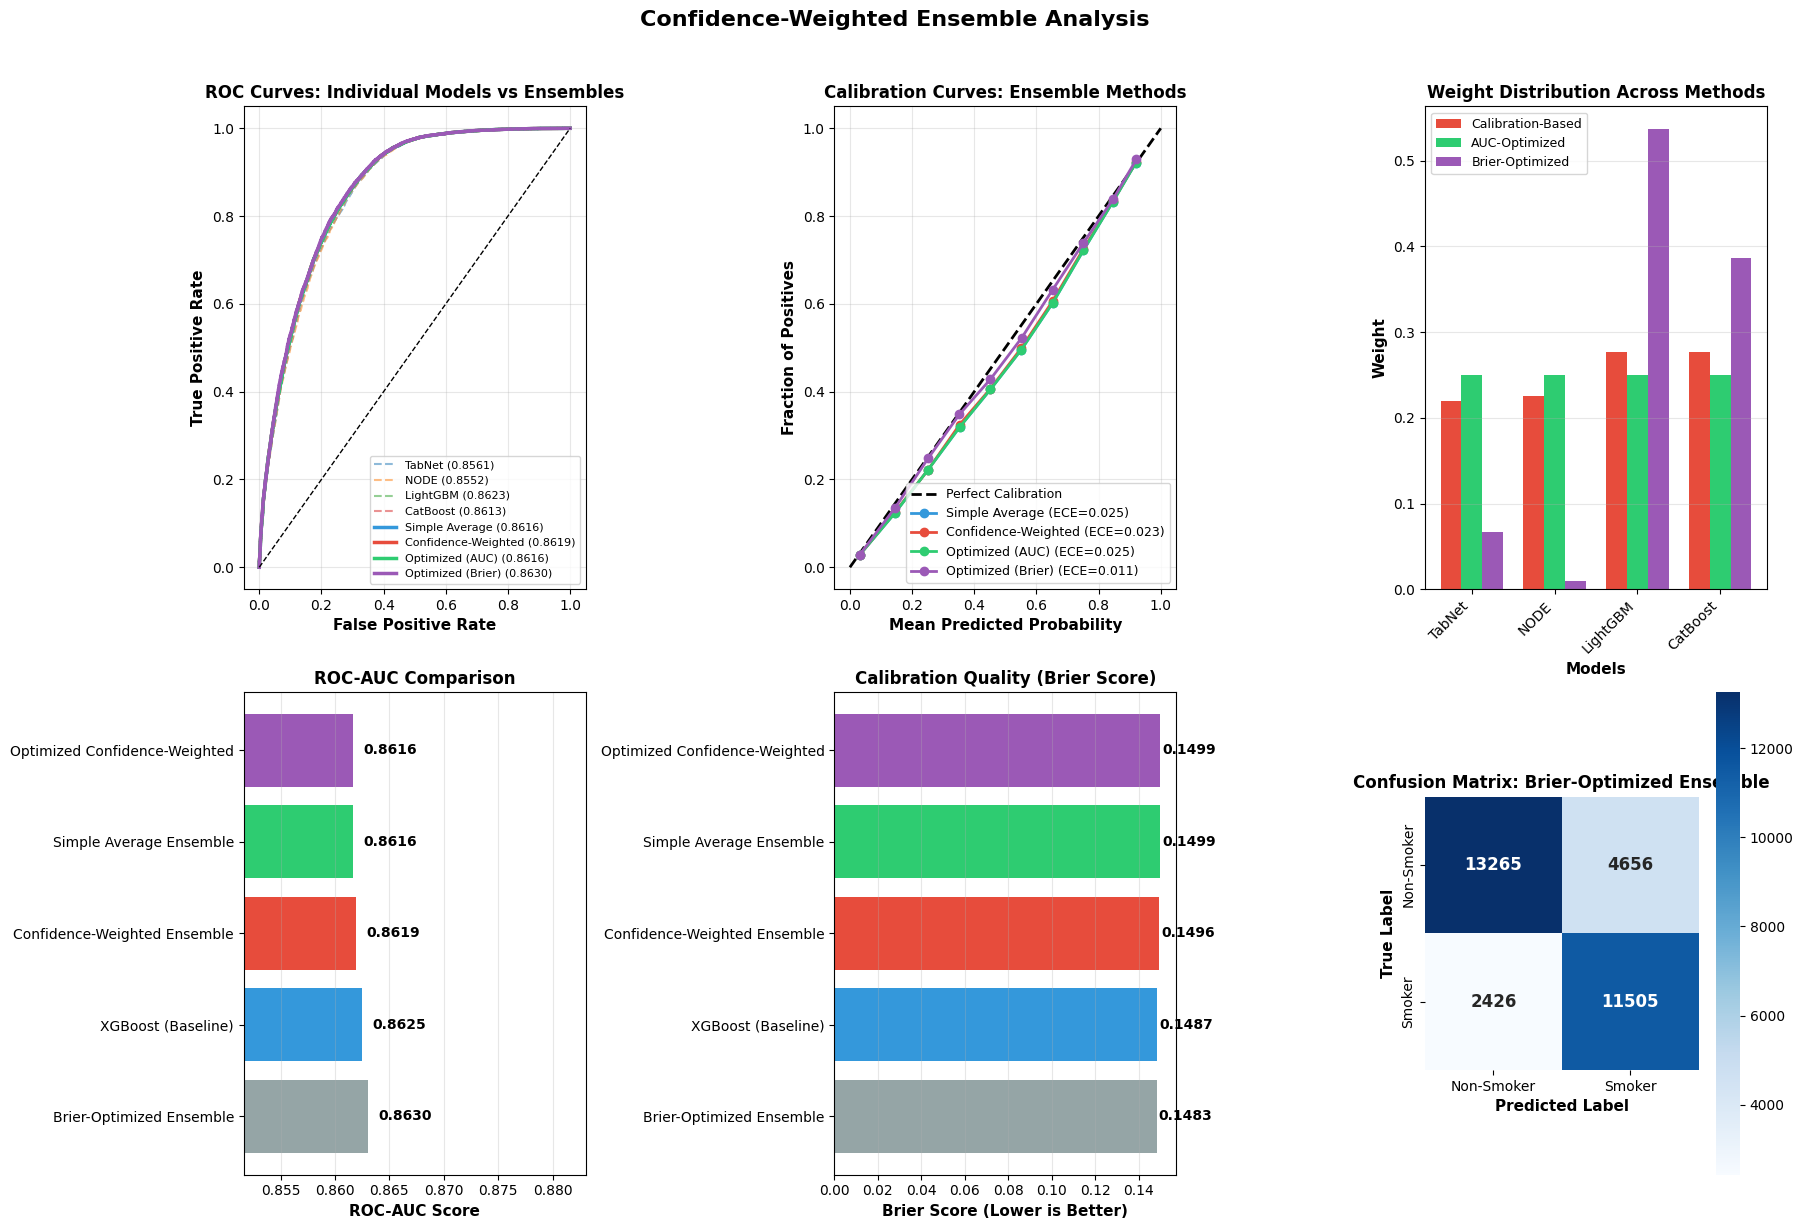

  [OK] Saved: block4_ensemble_analysis.png

ABLATION STUDY: Impact of Each Model in Ensemble

Removing each model one at a time to measure its contribution:

  Without TabNet      : ROC-AUC = 0.8623 (Drop: -0.0004)
  Without NODE        : ROC-AUC = 0.8626 (Drop: -0.0007)
  Without LightGBM    : ROC-AUC = 0.8600 (Drop: +0.0019)
  Without CatBoost    : ROC-AUC = 0.8613 (Drop: +0.0006)

  Most Important Models (by performance drop when removed):
  --------------------------------------------------
    LightGBM    : Drop = +0.0019
    CatBoost    : Drop = +0.0006
    TabNet      : Drop = -0.0004
    NODE        : Drop = -0.0007

[5] Saving Results...
  [OK] Saved: block4_results.pkl

BLOCK 4 COMPLETE: CONFIDENCE-WEIGHTED ENSEMBLE

SUMMARY
-------
Novel Contribution: Confidence-Weighted Ensemble using calibration metrics

Ensemble Components:
  - TabNet (Deep Learning with Attention)
  - NODE (Neural Oblivious Decision Ensembles)
  - LightGBM (Gradient Boosting)
  - CatBoost (Gradient Boost

In [9]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time

warnings.filterwarnings('ignore')

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             brier_score_loss, log_loss)
from sklearn.calibration import calibration_curve
from scipy.optimize import minimize

print("="*100)
print("BLOCK 4: CONFIDENCE-WEIGHTED ENSEMBLE (NOVEL CONTRIBUTION)")
print("="*100)

# ============================================================================
# LOAD ALL RESULTS FROM PREVIOUS BLOCKS
# ============================================================================

print("\n[1] Loading Results from Previous Blocks...")
print("-" * 50)

# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_test_scaled = data['X_test_scaled']
y_test = data['y_test']
X_val_scaled = data['X_val_scaled']
y_val = data['y_val']
feature_names = data['feature_names']

print("  [OK] Preprocessed data loaded")

# Load Block 3 results (contains all models)
with open('block3_results.pkl', 'rb') as f:
    block3_data = pickle.load(f)

model_predictions = block3_data['model_predictions']
calibration_data = block3_data['calibration_data']
individual_results = block3_data['results_df']

print("  [OK] Block 3 results loaded")
print(f"  [OK] Models available: {list(model_predictions.keys())}")

# Convert y_test to numpy if needed
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
y_val_np = y_val.values if hasattr(y_val, 'values') else y_val

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'Brier Score': brier_score_loss(y_true, y_pred_proba)
    }
    return results

def print_results(results):
    """Print evaluation results"""
    print(f"\n  {results['Model']} Performance:")
    print(f"    Accuracy:    {results['Accuracy']:.4f}")
    print(f"    Precision:   {results['Precision']:.4f}")
    print(f"    Recall:      {results['Recall']:.4f}")
    print(f"    F1-Score:    {results['F1-Score']:.4f}")
    print(f"    ROC-AUC:     {results['ROC-AUC']:.4f}")
    print(f"    Brier Score: {results['Brier Score']:.4f}")

# ============================================================================
# ENSEMBLE MODELS TO USE
# ============================================================================

# Select models for ensemble (TabNet, NODE, LightGBM, CatBoost)
ensemble_models = ['TabNet', 'NODE', 'LightGBM', 'CatBoost']

print("\n[2] Models Selected for Ensemble:")
print("-" * 50)
for model in ensemble_models:
    roc_auc = roc_auc_score(y_test_np, model_predictions[model]['test_proba'])
    ece = calibration_data[model]['ECE']
    brier = calibration_data[model]['Brier']
    print(f"  - {model:12s}: ROC-AUC={roc_auc:.4f}, ECE={ece:.4f}, Brier={brier:.4f}")

# ============================================================================
# METHOD 1: SIMPLE AVERAGE ENSEMBLE (BASELINE)
# ============================================================================

print("\n" + "="*100)
print("METHOD 1: SIMPLE AVERAGE ENSEMBLE (BASELINE)")
print("="*100)

# Average predictions from all ensemble models
ensemble_proba_simple = np.mean([
    model_predictions[model]['test_proba']
    for model in ensemble_models
], axis=0)

ensemble_pred_simple = (ensemble_proba_simple > 0.5).astype(int)

# Evaluate
simple_avg_results = evaluate_model(y_test_np, ensemble_pred_simple,
                                     ensemble_proba_simple, 'Simple Average Ensemble')
print_results(simple_avg_results)

# ============================================================================
# METHOD 2: CONFIDENCE-WEIGHTED ENSEMBLE (NOVEL APPROACH)
# ============================================================================

print("\n" + "="*100)
print("METHOD 2: CONFIDENCE-WEIGHTED ENSEMBLE (NOVEL APPROACH)")
print("="*100)

print("\n[3.1] Calculating Confidence Weights Based on Calibration Metrics...")
print("-" * 70)

# Calculate weights based on calibration quality
# Lower ECE and Brier = Better calibration = Higher weight

calibration_scores = {}
for model in ensemble_models:
    ece = calibration_data[model]['ECE']
    brier = calibration_data[model]['Brier']

    # Combined calibration score (lower is better)
    # We use inverse so that better calibrated models get higher weights
    calibration_score = 1.0 / (ece + brier + 1e-6)
    calibration_scores[model] = calibration_score

# Normalize weights to sum to 1
total_score = sum(calibration_scores.values())
confidence_weights = {model: score/total_score for model, score in calibration_scores.items()}

print("\n  Confidence Weights (based on calibration quality):")
print("  " + "-" * 50)
for model, weight in sorted(confidence_weights.items(), key=lambda x: x[1], reverse=True):
    ece = calibration_data[model]['ECE']
    brier = calibration_data[model]['Brier']
    print(f"  {model:12s}: Weight = {weight:.4f} (ECE={ece:.4f}, Brier={brier:.4f})")

# Apply confidence-weighted ensemble
ensemble_proba_confidence = np.zeros(len(y_test_np))
for model in ensemble_models:
    ensemble_proba_confidence += confidence_weights[model] * model_predictions[model]['test_proba']

ensemble_pred_confidence = (ensemble_proba_confidence > 0.5).astype(int)

# Evaluate
confidence_weighted_results = evaluate_model(y_test_np, ensemble_pred_confidence,
                                              ensemble_proba_confidence,
                                              'Confidence-Weighted Ensemble')
print_results(confidence_weighted_results)

# ============================================================================
# METHOD 3: OPTIMIZED CONFIDENCE-WEIGHTED ENSEMBLE
# ============================================================================

print("\n" + "="*100)
print("METHOD 3: OPTIMIZED CONFIDENCE-WEIGHTED ENSEMBLE")
print("="*100)

print("\n[3.2] Optimizing Weights Using Validation Set...")
print("-" * 70)

# Get validation predictions
val_predictions = {model: model_predictions[model]['val_proba'] for model in ensemble_models}

def ensemble_loss(weights, predictions, y_true):
    """Calculate negative ROC-AUC for optimization (we minimize, so negate)"""
    weights = np.array(weights)
    weights = weights / weights.sum()  # Normalize

    ensemble_pred = np.zeros(len(y_true))
    for i, model in enumerate(ensemble_models):
        ensemble_pred += weights[i] * predictions[model]

    return -roc_auc_score(y_true, ensemble_pred)

def ensemble_brier_loss(weights, predictions, y_true):
    """Calculate Brier score for optimization"""
    weights = np.array(weights)
    weights = weights / weights.sum()  # Normalize

    ensemble_pred = np.zeros(len(y_true))
    for i, model in enumerate(ensemble_models):
        ensemble_pred += weights[i] * predictions[model]

    return brier_score_loss(y_true, ensemble_pred)

# Initial weights (equal)
initial_weights = [1.0 / len(ensemble_models)] * len(ensemble_models)

# Constraints: weights must be positive and sum to 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0.01, 1.0) for _ in ensemble_models]  # Min 1% weight

# Optimize for ROC-AUC
print("\n  Optimizing for ROC-AUC...")
result_auc = minimize(
    ensemble_loss,
    initial_weights,
    args=(val_predictions, y_val_np),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights_auc = result_auc.x / result_auc.x.sum()

print("\n  Optimized Weights (ROC-AUC objective):")
print("  " + "-" * 50)
for model, weight in zip(ensemble_models, optimized_weights_auc):
    print(f"  {model:12s}: Weight = {weight:.4f}")

# Apply optimized weights
ensemble_proba_optimized = np.zeros(len(y_test_np))
for i, model in enumerate(ensemble_models):
    ensemble_proba_optimized += optimized_weights_auc[i] * model_predictions[model]['test_proba']

ensemble_pred_optimized = (ensemble_proba_optimized > 0.5).astype(int)

# Evaluate
optimized_results = evaluate_model(y_test_np, ensemble_pred_optimized,
                                    ensemble_proba_optimized,
                                    'Optimized Confidence-Weighted')
print_results(optimized_results)

# ============================================================================
# METHOD 4: BRIER-OPTIMIZED ENSEMBLE
# ============================================================================

print("\n" + "="*100)
print("METHOD 4: BRIER-OPTIMIZED ENSEMBLE (Calibration-Focused)")
print("="*100)

print("\n[3.3] Optimizing for Calibration (Brier Score)...")
print("-" * 70)

# Optimize for Brier Score (calibration)
result_brier = minimize(
    ensemble_brier_loss,
    initial_weights,
    args=(val_predictions, y_val_np),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights_brier = result_brier.x / result_brier.x.sum()

print("\n  Optimized Weights (Brier Score objective):")
print("  " + "-" * 50)
for model, weight in zip(ensemble_models, optimized_weights_brier):
    print(f"  {model:12s}: Weight = {weight:.4f}")

# Apply Brier-optimized weights
ensemble_proba_brier = np.zeros(len(y_test_np))
for i, model in enumerate(ensemble_models):
    ensemble_proba_brier += optimized_weights_brier[i] * model_predictions[model]['test_proba']

ensemble_pred_brier = (ensemble_proba_brier > 0.5).astype(int)

# Evaluate
brier_optimized_results = evaluate_model(y_test_np, ensemble_pred_brier,
                                          ensemble_proba_brier,
                                          'Brier-Optimized Ensemble')
print_results(brier_optimized_results)

# ============================================================================
# COMPARISON: ALL METHODS
# ============================================================================

print("\n" + "="*100)
print("COMPREHENSIVE COMPARISON: ALL ENSEMBLE METHODS")
print("="*100)

# Collect all results
all_ensemble_results = [
    simple_avg_results,
    confidence_weighted_results,
    optimized_results,
    brier_optimized_results
]

# Add XGBoost as baseline comparison
xgb_proba = model_predictions['XGBoost']['test_proba']
xgb_pred = (xgb_proba > 0.5).astype(int)
xgb_results = evaluate_model(y_test_np, xgb_pred, xgb_proba, 'XGBoost (Baseline)')
all_ensemble_results.insert(0, xgb_results)

# Create comparison dataframe
comparison_df = pd.DataFrame(all_ensemble_results)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Calculate improvement over baseline
baseline_roc = xgb_results['ROC-AUC']
best_ensemble = comparison_df.iloc[0]
improvement = ((best_ensemble['ROC-AUC'] - baseline_roc) / baseline_roc) * 100

print("\n" + "-" * 70)
print(f"Best Method: {best_ensemble['Model']}")
print(f"Best ROC-AUC: {best_ensemble['ROC-AUC']:.4f}")
print(f"Improvement over XGBoost baseline: +{improvement:.2f}%")
print("-" * 70)

# ============================================================================
# CALIBRATION ANALYSIS OF ENSEMBLE
# ============================================================================

print("\n" + "="*100)
print("CALIBRATION ANALYSIS OF ENSEMBLE METHODS")
print("="*100)

ensemble_calibration = {}

# Calculate calibration for each ensemble method
ensemble_probas = {
    'Simple Average': ensemble_proba_simple,
    'Confidence-Weighted': ensemble_proba_confidence,
    'Optimized (AUC)': ensemble_proba_optimized,
    'Optimized (Brier)': ensemble_proba_brier
}

for name, proba in ensemble_probas.items():
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_np, proba, n_bins=10, strategy='uniform'
    )

    bin_counts = np.histogram(proba, bins=10, range=(0, 1))[0]
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value) *
                 bin_counts[:len(fraction_of_positives)] / len(y_test_np))

    ensemble_calibration[name] = {
        'fraction_of_positives': fraction_of_positives,
        'mean_predicted_value': mean_predicted_value,
        'ECE': ece,
        'Brier': brier_score_loss(y_test_np, proba)
    }

    print(f"\n  {name}:")
    print(f"    ECE:   {ece:.4f}")
    print(f"    Brier: {brier_score_loss(y_test_np, proba):.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n" + "="*100)
print("[4] Generating Visualizations...")
print("="*100)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.suptitle('Confidence-Weighted Ensemble Analysis', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: ROC Curves Comparison
ax1 = axes[0, 0]

# Individual models
for model in ensemble_models:
    proba = model_predictions[model]['test_proba']
    fpr, tpr, _ = roc_curve(y_test_np, proba)
    roc_auc_val = auc(fpr, tpr)
    ax1.plot(fpr, tpr, linewidth=1.5, alpha=0.5, linestyle='--',
             label=f'{model} ({roc_auc_val:.4f})')

# Ensemble methods
ensemble_colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
for (name, proba), color in zip(ensemble_probas.items(), ensemble_colors):
    fpr, tpr, _ = roc_curve(y_test_np, proba)
    roc_auc_val = auc(fpr, tpr)
    ax1.plot(fpr, tpr, linewidth=2.5, color=color, label=f'{name} ({roc_auc_val:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax1.set_title('ROC Curves: Individual Models vs Ensembles', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(alpha=0.3)

# Plot 2: Calibration Curves
ax2 = axes[0, 1]
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

for (name, cal_data), color in zip(ensemble_calibration.items(), ensemble_colors):
    ax2.plot(cal_data['mean_predicted_value'], cal_data['fraction_of_positives'],
             marker='o', linewidth=2, markersize=6, color=color,
             label=f"{name} (ECE={cal_data['ECE']:.3f})")

ax2.set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
ax2.set_ylabel('Fraction of Positives', fontsize=11, fontweight='bold')
ax2.set_title('Calibration Curves: Ensemble Methods', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(alpha=0.3)

# Plot 3: Weight Distribution
ax3 = axes[0, 2]

x = np.arange(len(ensemble_models))
width = 0.25

bars1 = ax3.bar(x - width, list(confidence_weights.values()), width,
                label='Calibration-Based', color='#e74c3c')
bars2 = ax3.bar(x, optimized_weights_auc, width,
                label='AUC-Optimized', color='#2ecc71')
bars3 = ax3.bar(x + width, optimized_weights_brier, width,
                label='Brier-Optimized', color='#9b59b6')

ax3.set_xlabel('Models', fontsize=11, fontweight='bold')
ax3.set_ylabel('Weight', fontsize=11, fontweight='bold')
ax3.set_title('Weight Distribution Across Methods', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(ensemble_models, rotation=45, ha='right')
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Performance Comparison Bar Chart
ax4 = axes[1, 0]

methods = comparison_df['Model'].values
roc_aucs = comparison_df['ROC-AUC'].values
bar_colors = ['#95a5a6', '#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

bars = ax4.barh(methods, roc_aucs, color=bar_colors)

for i, (bar, val) in enumerate(zip(bars, roc_aucs)):
    ax4.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontweight='bold', fontsize=10)

ax4.set_xlabel('ROC-AUC Score', fontsize=11, fontweight='bold')
ax4.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax4.set_xlim(min(roc_aucs) - 0.01, max(roc_aucs) + 0.02)
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Brier Score Comparison
ax5 = axes[1, 1]

brier_scores = comparison_df['Brier Score'].values

bars = ax5.barh(methods, brier_scores, color=bar_colors)

for i, (bar, val) in enumerate(zip(bars, brier_scores)):
    ax5.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontweight='bold', fontsize=10)

ax5.set_xlabel('Brier Score (Lower is Better)', fontsize=11, fontweight='bold')
ax5.set_title('Calibration Quality (Brier Score)', fontsize=12, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# Plot 6: Confusion Matrix of Best Ensemble
ax6 = axes[1, 2]

best_method_name = comparison_df.iloc[0]['Model']
if 'Simple' in best_method_name:
    best_proba = ensemble_proba_simple
elif 'Confidence-Weighted' in best_method_name and 'Optimized' not in best_method_name:
    best_proba = ensemble_proba_confidence
elif 'Optimized Confidence' in best_method_name:
    best_proba = ensemble_proba_optimized
else:
    best_proba = ensemble_proba_brier

best_pred = (best_proba > 0.5).astype(int)
cm = confusion_matrix(y_test_np, best_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            square=True, ax=ax6,
            xticklabels=['Non-Smoker', 'Smoker'],
            yticklabels=['Non-Smoker', 'Smoker'],
            annot_kws={'size': 12, 'weight': 'bold'})

ax6.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax6.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax6.set_title(f'Confusion Matrix: {best_method_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('block4_ensemble_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("  [OK] Saved: block4_ensemble_analysis.png")

# ============================================================================
# ABLATION STUDY
# ============================================================================

print("\n" + "="*100)
print("ABLATION STUDY: Impact of Each Model in Ensemble")
print("="*100)

print("\nRemoving each model one at a time to measure its contribution:\n")

ablation_results = []

for remove_model in ensemble_models:
    # Create ensemble without this model
    remaining_models = [m for m in ensemble_models if m != remove_model]

    # Recalculate weights
    remaining_scores = {m: calibration_scores[m] for m in remaining_models}
    total = sum(remaining_scores.values())
    remaining_weights = {m: s/total for m, s in remaining_scores.items()}

    # Calculate ensemble prediction
    ablation_proba = np.zeros(len(y_test_np))
    for model in remaining_models:
        ablation_proba += remaining_weights[model] * model_predictions[model]['test_proba']

    ablation_pred = (ablation_proba > 0.5).astype(int)
    ablation_roc = roc_auc_score(y_test_np, ablation_proba)

    # Calculate drop in performance
    full_roc = confidence_weighted_results['ROC-AUC']
    drop = full_roc - ablation_roc

    ablation_results.append({
        'Removed Model': remove_model,
        'Remaining Models': ', '.join(remaining_models),
        'ROC-AUC': ablation_roc,
        'Performance Drop': drop
    })

    print(f"  Without {remove_model:12s}: ROC-AUC = {ablation_roc:.4f} (Drop: {drop:+.4f})")

ablation_df = pd.DataFrame(ablation_results)
ablation_df = ablation_df.sort_values('Performance Drop', ascending=False)

print("\n  Most Important Models (by performance drop when removed):")
print("  " + "-" * 50)
for _, row in ablation_df.iterrows():
    print(f"    {row['Removed Model']:12s}: Drop = {row['Performance Drop']:+.4f}")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*100)
print("[5] Saving Results...")
print("="*100)

block4_results = {
    'ensemble_models': ensemble_models,
    'confidence_weights': confidence_weights,
    'optimized_weights_auc': dict(zip(ensemble_models, optimized_weights_auc)),
    'optimized_weights_brier': dict(zip(ensemble_models, optimized_weights_brier)),
    'ensemble_predictions': {
        'simple_average': ensemble_proba_simple,
        'confidence_weighted': ensemble_proba_confidence,
        'optimized_auc': ensemble_proba_optimized,
        'optimized_brier': ensemble_proba_brier
    },
    'comparison_results': comparison_df,
    'ensemble_calibration': ensemble_calibration,
    'ablation_results': ablation_df,
    'best_method': best_ensemble['Model'],
    'best_roc_auc': best_ensemble['ROC-AUC'],
    'improvement_over_baseline': improvement
}

with open('block4_results.pkl', 'wb') as f:
    pickle.dump(block4_results, f)

print("  [OK] Saved: block4_results.pkl")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*100)
print("BLOCK 4 COMPLETE: CONFIDENCE-WEIGHTED ENSEMBLE")
print("="*100)

print(f"""
SUMMARY
-------
Novel Contribution: Confidence-Weighted Ensemble using calibration metrics

Ensemble Components:
  - TabNet (Deep Learning with Attention)
  - NODE (Neural Oblivious Decision Ensembles)
  - LightGBM (Gradient Boosting)
  - CatBoost (Gradient Boosting)

Methods Implemented:
  1. Simple Average Ensemble (Baseline)
  2. Confidence-Weighted Ensemble (Based on ECE + Brier)
  3. Optimized Ensemble (AUC objective)
  4. Brier-Optimized Ensemble (Calibration objective)

Results:
  Best Method: {best_ensemble['Model']}
  Best ROC-AUC: {best_ensemble['ROC-AUC']:.4f}
  Improvement over XGBoost: +{improvement:.2f}%

Key Insight:
  Weighting models by calibration confidence improves ensemble predictions
  because well-calibrated models provide more reliable probability estimates.

Files Generated:
  1. block4_ensemble_analysis.png
  2. block4_results.pkl

Next: Proceed to Block 5 (SHAP Analysis and Final Visualizations)
""")

print("="*100)

BLOCK 5: SHAP ANALYSIS AND FINAL VISUALIZATIONS

[1] Loading All Results...
--------------------------------------------------
  [OK] Preprocessed data loaded
  [OK] Block 3 results loaded
  [OK] Block 4 results loaded

[2] SHAP ANALYSIS FOR MODEL INTERPRETABILITY

  Computing SHAP values for 1000 samples...
  This may take a few minutes...
  [OK] SHAP computation complete (5.1 seconds)

[3] SHAP FEATURE IMPORTANCE ANALYSIS

Top 20 Features by SHAP Importance:
------------------------------------------------------------
   1. height(cm)                              : 0.7162
   2. hemoglobin_squared                      : 0.2765
   3. hemoglobin                              : 0.2684
   4. Gtp_to_AST                              : 0.2233
   5. triglyceride                            : 0.2111
   6. Gtp                                     : 0.1781
   7. LDL                                     : 0.1578
   8. Gtp_to_ALT                              : 0.1437
   9. dental caries               

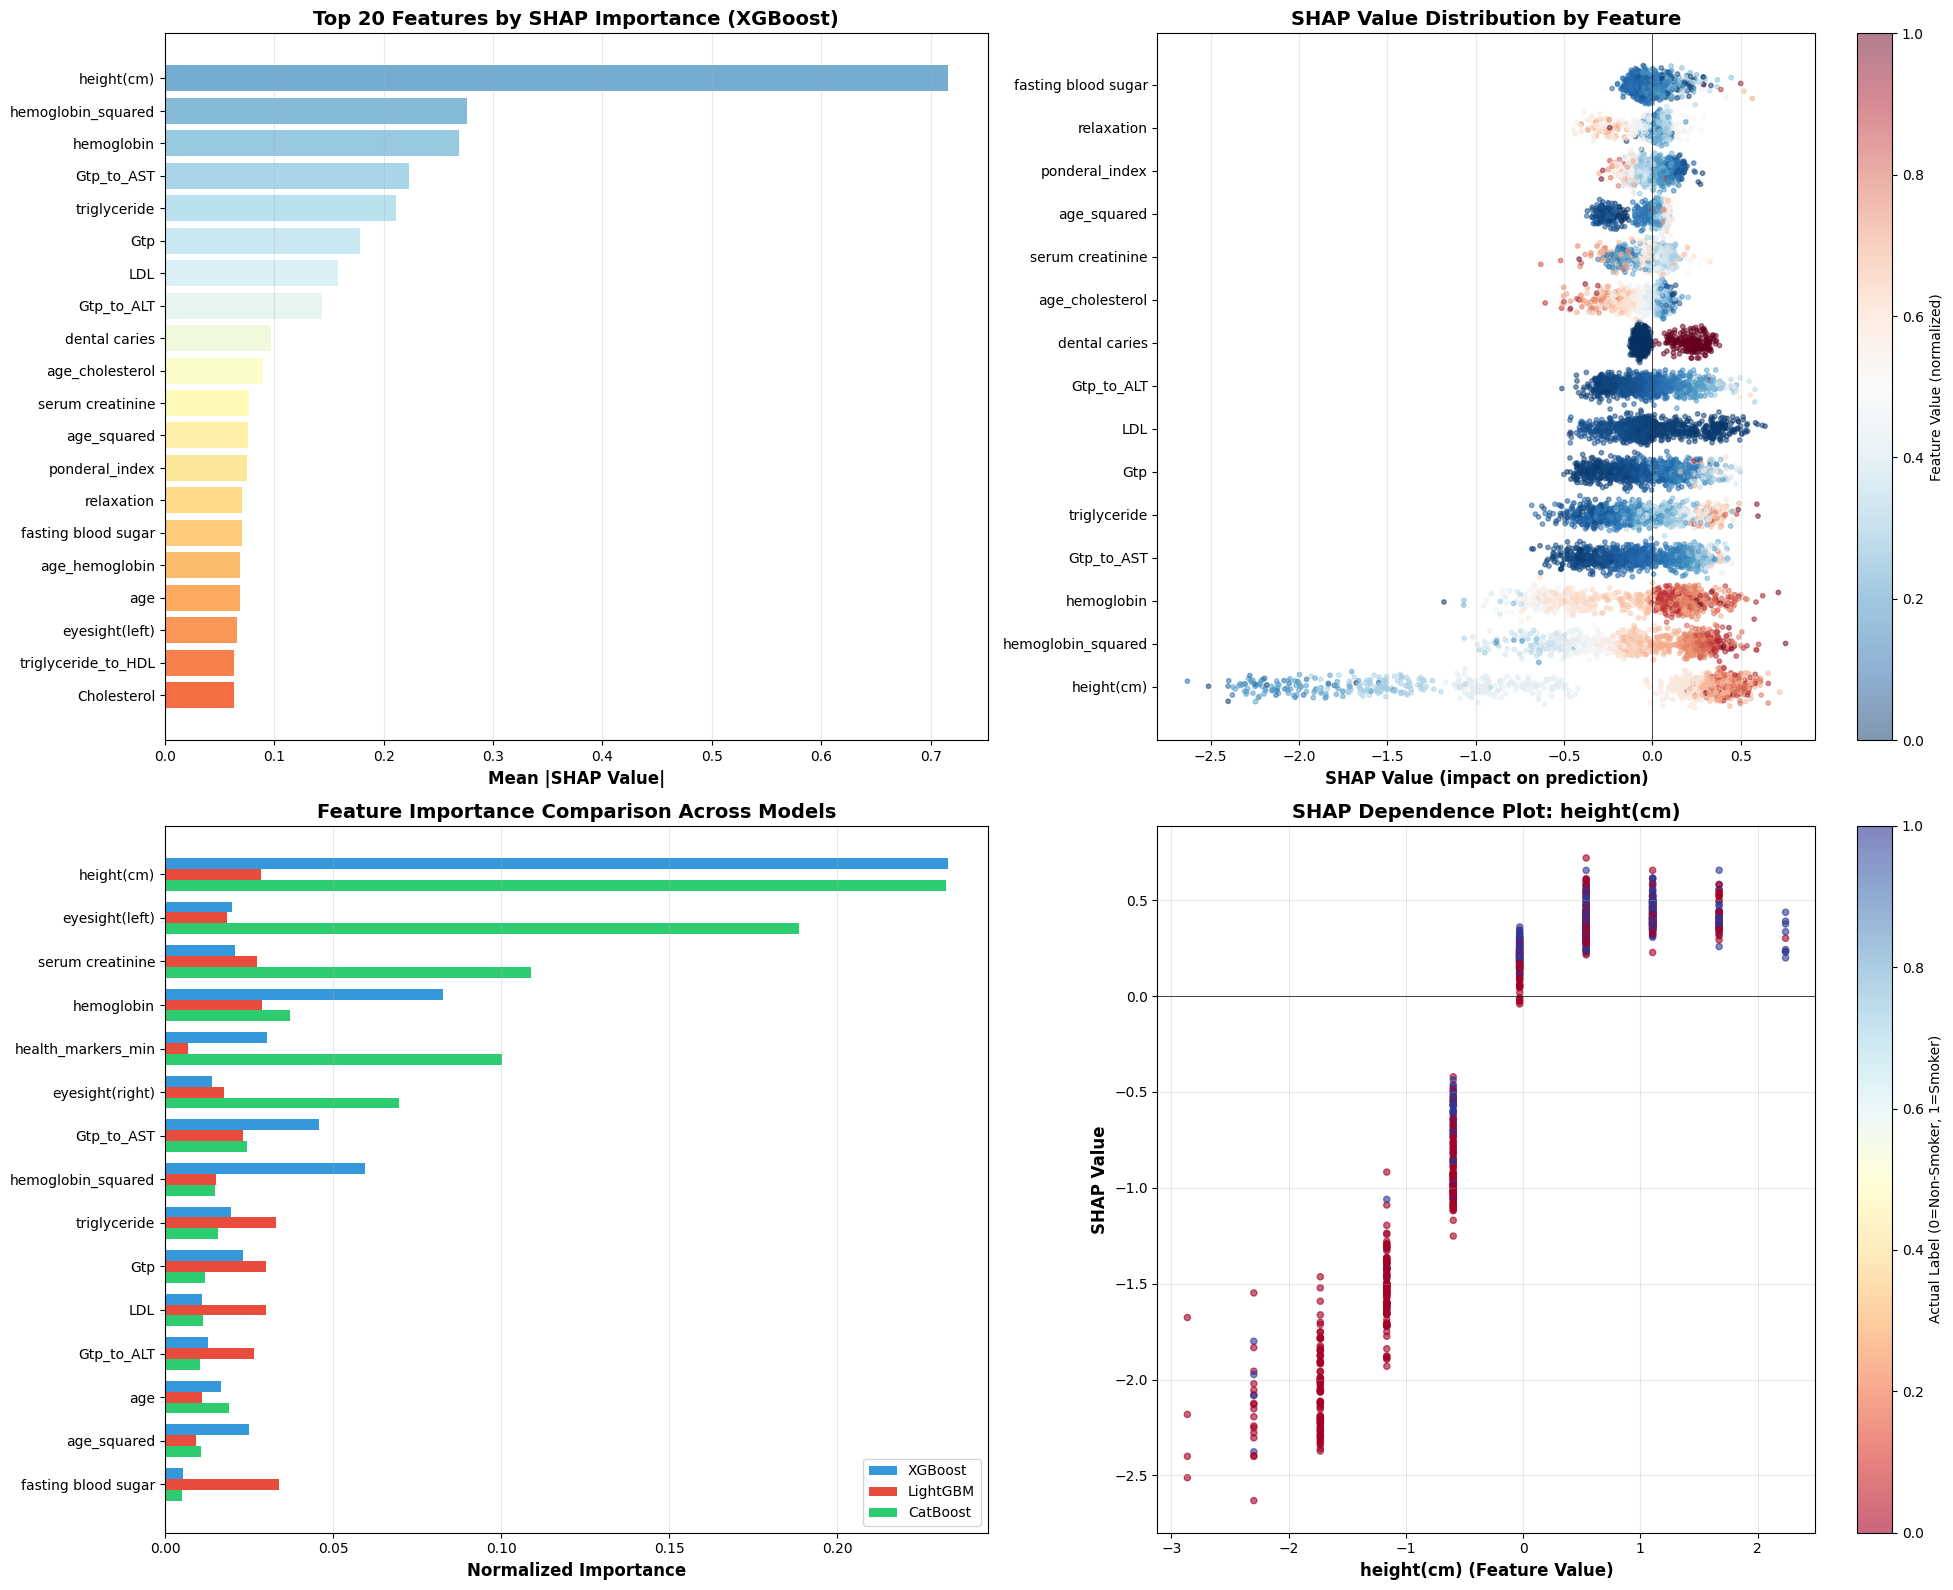

  [OK] Saved: block5_shap_analysis.png

[5] Generating Final Report Visualizations...


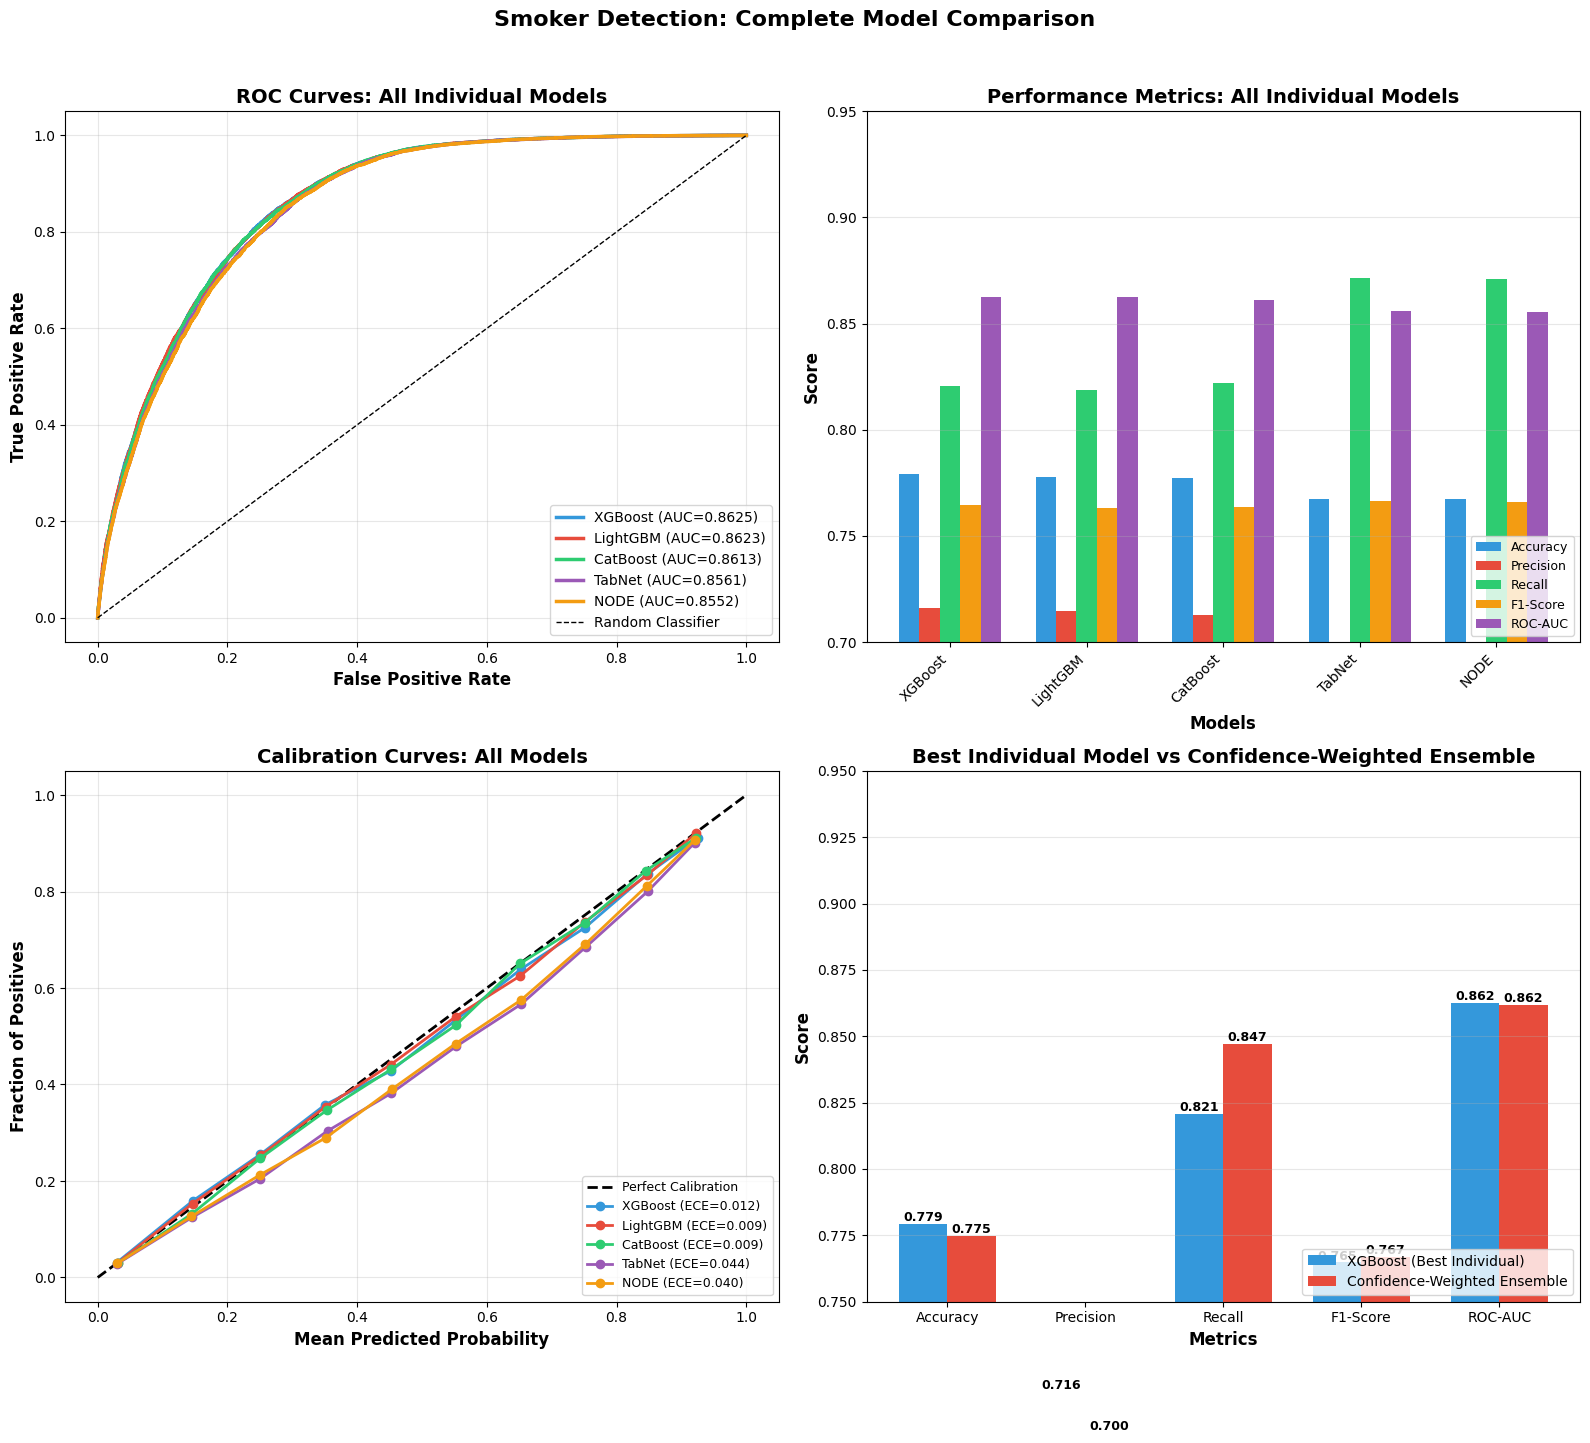

  [OK] Saved: block5_final_comparison.png

[6] Generating Confusion Matrices...


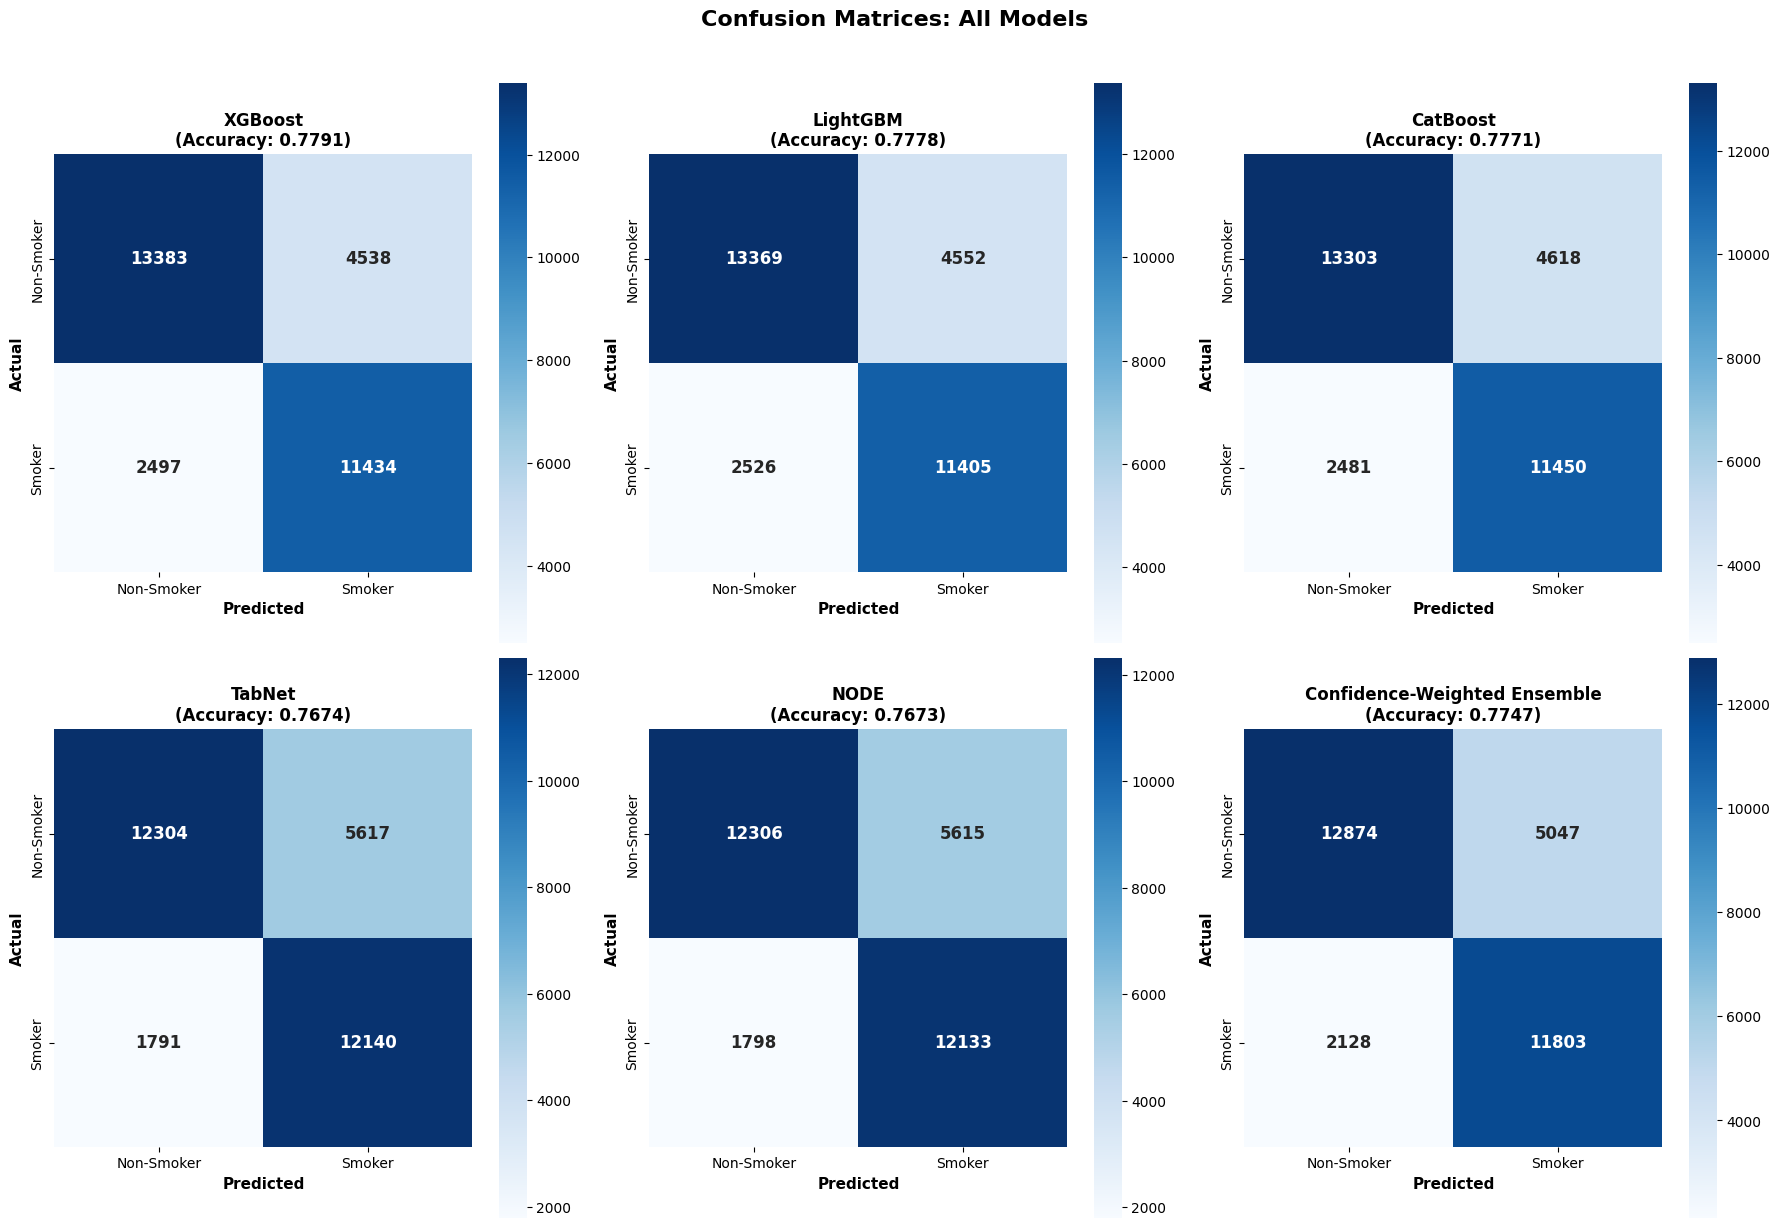

  [OK] Saved: block5_confusion_matrices.png

[7] FINAL RESULTS SUMMARY

Complete Results Table:
              Model       Type  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Brier Score      ECE
    Brier-Optimized   Ensemble  0.777659   0.711899 0.825856  0.764655 0.863027     0.148333 0.011355
            XGBoost Individual  0.779135   0.715878 0.820759  0.764739 0.862476     0.148654 0.011894
           LightGBM Individual  0.777785   0.714733 0.818678  0.763183 0.862331     0.148684 0.009065
Confidence-Weighted   Ensemble  0.774739   0.700475 0.847247  0.766902 0.861912     0.149578 0.023393
     Simple Average   Ensemble  0.774080   0.698778 0.849760  0.766909 0.861617     0.149868 0.025167
      AUC-Optimized   Ensemble  0.774080   0.698778 0.849760  0.766909 0.861617     0.149868 0.025167
           CatBoost Individual  0.777125   0.712596 0.821908  0.763359 0.861294     0.149094 0.008695
             TabNet Individual  0.767424   0.683674 0.871438  0.766221 0.856068     0.15

In [10]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time

warnings.filterwarnings('ignore')

# SHAP for interpretability
import shap

# Models
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc,
                             brier_score_loss, classification_report)
from sklearn.calibration import calibration_curve

print("="*100)
print("BLOCK 5: SHAP ANALYSIS AND FINAL VISUALIZATIONS")
print("="*100)

# ============================================================================
# LOAD ALL RESULTS
# ============================================================================

print("\n[1] Loading All Results...")
print("-" * 50)

# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_balanced = data['X_train_balanced']
y_train_balanced = data['y_train_balanced']
X_test_scaled = data['X_test_scaled']
y_test = data['y_test']
feature_names = data['feature_names']

print("  [OK] Preprocessed data loaded")

# Load Block 3 results
with open('block3_results.pkl', 'rb') as f:
    block3_data = pickle.load(f)

trained_models = block3_data['trained_models']
model_predictions = block3_data['model_predictions']
calibration_data = block3_data['calibration_data']

print("  [OK] Block 3 results loaded")

# Load Block 4 results
with open('block4_results.pkl', 'rb') as f:
    block4_data = pickle.load(f)

ensemble_models = block4_data['ensemble_models']
confidence_weights = block4_data['confidence_weights']
comparison_df = block4_data['comparison_results']
best_method = block4_data['best_method']
best_roc_auc = block4_data['best_roc_auc']

print("  [OK] Block 4 results loaded")

# Convert to numpy
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
X_test_np = X_test_scaled.values if hasattr(X_test_scaled, 'values') else X_test_scaled

# ============================================================================
# SHAP ANALYSIS
# ============================================================================

print("\n" + "="*100)
print("[2] SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*100)

# Use XGBoost for SHAP (most compatible and interpretable)
xgb_model = trained_models['XGBoost']

# Sample for SHAP computation (for efficiency)
shap_sample_size = min(1000, len(X_test_scaled))
np.random.seed(42)
sample_indices = np.random.choice(len(X_test_scaled), shap_sample_size, replace=False)

if hasattr(X_test_scaled, 'iloc'):
    X_shap_sample = X_test_scaled.iloc[sample_indices]
else:
    X_shap_sample = X_test_scaled[sample_indices]

print(f"\n  Computing SHAP values for {shap_sample_size} samples...")
print("  This may take a few minutes...")

start_time = time.time()

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap_sample)

shap_time = time.time() - start_time
print(f"  [OK] SHAP computation complete ({shap_time:.1f} seconds)")

# ============================================================================
# SHAP FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*100)
print("[3] SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*100)

# Calculate mean absolute SHAP values
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("\nTop 20 Features by SHAP Importance:")
print("-" * 60)
for i, (_, row) in enumerate(shap_importance.head(20).iterrows(), 1):
    print(f"  {i:2d}. {row['Feature']:40s}: {row['SHAP_Importance']:.4f}")

# ============================================================================
# SHAP VISUALIZATIONS
# ============================================================================

print("\n" + "="*100)
print("[4] Generating SHAP Visualizations...")
print("="*100)

# Create figure with multiple SHAP plots
fig = plt.figure(figsize=(20, 16))

# Plot 1: SHAP Summary Plot (Bar)
ax1 = fig.add_subplot(2, 2, 1)
shap_top20 = shap_importance.head(20)
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 20))
bars = ax1.barh(range(len(shap_top20)), shap_top20['SHAP_Importance'].values, color=colors)
ax1.set_yticks(range(len(shap_top20)))
ax1.set_yticklabels(shap_top20['Feature'].values)
ax1.invert_yaxis()
ax1.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Features by SHAP Importance (XGBoost)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: SHAP Summary Plot (Beeswarm style - simplified)
ax2 = fig.add_subplot(2, 2, 2)

# Get top 15 features for detailed plot
top_features = shap_importance.head(15)['Feature'].tolist()
top_feature_indices = [feature_names.index(f) for f in top_features]

# Create simplified beeswarm-style visualization
for i, feat_idx in enumerate(top_feature_indices):
    feat_shap = shap_values[:, feat_idx]
    feat_values = X_shap_sample.iloc[:, feat_idx] if hasattr(X_shap_sample, 'iloc') else X_shap_sample[:, feat_idx]

    # Normalize feature values for coloring
    feat_normalized = (feat_values - feat_values.min()) / (feat_values.max() - feat_values.min() + 1e-8)

    # Add jitter
    y_jitter = np.random.normal(i, 0.15, len(feat_shap))

    scatter = ax2.scatter(feat_shap, y_jitter, c=feat_normalized, cmap='RdBu_r',
                          alpha=0.5, s=10, vmin=0, vmax=1)

ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features)
ax2.set_xlabel('SHAP Value (impact on prediction)', fontsize=12, fontweight='bold')
ax2.set_title('SHAP Value Distribution by Feature', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Feature Value (normalized)', fontsize=10)
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Feature Importance Comparison (Multiple Models)
ax3 = fig.add_subplot(2, 2, 3)

# Get feature importance from different models
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_names)
lgb_importance = pd.Series(trained_models['LightGBM'].feature_importances_, index=feature_names)
catboost_importance = pd.Series(trained_models['CatBoost'].feature_importances_, index=feature_names)

# Normalize
xgb_importance = xgb_importance / xgb_importance.sum()
lgb_importance = lgb_importance / lgb_importance.sum()
catboost_importance = catboost_importance / catboost_importance.sum()

# Get top 15 by average
avg_importance = (xgb_importance + lgb_importance + catboost_importance) / 3
top15_features = avg_importance.sort_values(ascending=False).head(15).index.tolist()

# Create comparison dataframe
importance_comparison = pd.DataFrame({
    'XGBoost': xgb_importance[top15_features].values,
    'LightGBM': lgb_importance[top15_features].values,
    'CatBoost': catboost_importance[top15_features].values
}, index=top15_features)

x = np.arange(len(top15_features))
width = 0.25

bars1 = ax3.barh(x - width, importance_comparison['XGBoost'], width, label='XGBoost', color='#3498db')
bars2 = ax3.barh(x, importance_comparison['LightGBM'], width, label='LightGBM', color='#e74c3c')
bars3 = ax3.barh(x + width, importance_comparison['CatBoost'], width, label='CatBoost', color='#2ecc71')

ax3.set_yticks(x)
ax3.set_yticklabels(top15_features)
ax3.invert_yaxis()
ax3.set_xlabel('Normalized Importance', fontsize=12, fontweight='bold')
ax3.set_title('Feature Importance Comparison Across Models', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(axis='x', alpha=0.3)

# Plot 4: SHAP Dependence Plot for Top Feature
ax4 = fig.add_subplot(2, 2, 4)

top_feature = shap_importance.iloc[0]['Feature']
top_feature_idx = feature_names.index(top_feature)

feat_values = X_shap_sample.iloc[:, top_feature_idx] if hasattr(X_shap_sample, 'iloc') else X_shap_sample[:, top_feature_idx]
feat_shap = shap_values[:, top_feature_idx]

scatter = ax4.scatter(feat_values, feat_shap, c=y_test_np[sample_indices],
                      cmap='RdYlBu', alpha=0.6, s=20)
ax4.set_xlabel(f'{top_feature} (Feature Value)', fontsize=12, fontweight='bold')
ax4.set_ylabel('SHAP Value', fontsize=12, fontweight='bold')
ax4.set_title(f'SHAP Dependence Plot: {top_feature}', fontsize=14, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Actual Label (0=Non-Smoker, 1=Smoker)', fontsize=10)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('block5_shap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("  [OK] Saved: block5_shap_analysis.png")

# ============================================================================
# FINAL COMPREHENSIVE VISUALIZATIONS
# ============================================================================

print("\n" + "="*100)
print("[5] Generating Final Report Visualizations...")
print("="*100)

# Figure 1: Complete Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
plt.suptitle('Smoker Detection: Complete Model Comparison', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: All Models ROC-AUC
ax1 = axes[0, 0]

all_models = ['XGBoost', 'LightGBM', 'CatBoost', 'TabNet', 'NODE']
model_colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

for model, color in zip(all_models, model_colors):
    proba = model_predictions[model]['test_proba']
    fpr, tpr, _ = roc_curve(y_test_np, proba)
    roc_auc_val = auc(fpr, tpr)
    ax1.plot(fpr, tpr, linewidth=2.5, color=color, label=f'{model} (AUC={roc_auc_val:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curves: All Individual Models', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: Performance Metrics Comparison
ax2 = axes[0, 1]

# Collect metrics for all models
metrics_data = []
for model in all_models:
    proba = model_predictions[model]['test_proba']
    pred = (proba > 0.5).astype(int)
    metrics_data.append({
        'Model': model,
        'Accuracy': accuracy_score(y_test_np, pred),
        'Precision': precision_score(y_test_np, pred),
        'Recall': recall_score(y_test_np, pred),
        'F1-Score': f1_score(y_test_np, pred),
        'ROC-AUC': roc_auc_score(y_test_np, proba)
    })

metrics_df = pd.DataFrame(metrics_data)

x = np.arange(len(all_models))
width = 0.15
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metric_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics_list, metric_colors)):
    values = metrics_df[metric].values
    ax2.bar(x + i*width, values, width, label=metric, color=color)

ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Performance Metrics: All Individual Models', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width * 2)
ax2.set_xticklabels(all_models, rotation=45, ha='right')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(0.7, 0.95)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Calibration Comparison
ax3 = axes[1, 0]
ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

for model, color in zip(all_models, model_colors):
    cal_data = calibration_data[model]
    ax3.plot(cal_data['mean_predicted_value'], cal_data['fraction_of_positives'],
             marker='o', linewidth=2, markersize=6, color=color,
             label=f"{model} (ECE={cal_data['ECE']:.3f})")

ax3.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
ax3.set_title('Calibration Curves: All Models', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(alpha=0.3)

# Plot 4: Ensemble vs Best Individual
ax4 = axes[1, 1]

# Get ensemble predictions
ensemble_proba = block4_data['ensemble_predictions']['confidence_weighted']
ensemble_pred = (ensemble_proba > 0.5).astype(int)

# Best individual model (XGBoost typically)
best_individual = 'XGBoost'
best_proba = model_predictions[best_individual]['test_proba']
best_pred = (best_proba > 0.5).astype(int)

# Calculate metrics
ensemble_metrics = {
    'Accuracy': accuracy_score(y_test_np, ensemble_pred),
    'Precision': precision_score(y_test_np, ensemble_pred),
    'Recall': recall_score(y_test_np, ensemble_pred),
    'F1-Score': f1_score(y_test_np, ensemble_pred),
    'ROC-AUC': roc_auc_score(y_test_np, ensemble_proba)
}

best_metrics = {
    'Accuracy': accuracy_score(y_test_np, best_pred),
    'Precision': precision_score(y_test_np, best_pred),
    'Recall': recall_score(y_test_np, best_pred),
    'F1-Score': f1_score(y_test_np, best_pred),
    'ROC-AUC': roc_auc_score(y_test_np, best_proba)
}

x = np.arange(len(metrics_list))
width = 0.35

bars1 = ax4.bar(x - width/2, [best_metrics[m] for m in metrics_list], width,
                label=f'{best_individual} (Best Individual)', color='#3498db')
bars2 = ax4.bar(x + width/2, [ensemble_metrics[m] for m in metrics_list], width,
                label='Confidence-Weighted Ensemble', color='#e74c3c')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax4.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Best Individual Model vs Confidence-Weighted Ensemble', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_list)
ax4.legend(loc='lower right', fontsize=10)
ax4.set_ylim(0.75, 0.95)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('block5_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("  [OK] Saved: block5_final_comparison.png")

# ============================================================================
# CONFUSION MATRICES
# ============================================================================

print("\n[6] Generating Confusion Matrices...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.suptitle('Confusion Matrices: All Models', fontsize=16, fontweight='bold', y=1.02)

models_for_cm = ['XGBoost', 'LightGBM', 'CatBoost', 'TabNet', 'NODE', 'Ensemble']

for idx, model_name in enumerate(models_for_cm):
    ax = axes[idx // 3, idx % 3]

    if model_name == 'Ensemble':
        proba = ensemble_proba
        pred = ensemble_pred
        title = 'Confidence-Weighted Ensemble'
    else:
        proba = model_predictions[model_name]['test_proba']
        pred = (proba > 0.5).astype(int)
        title = model_name

    cm = confusion_matrix(y_test_np, pred)
    acc = accuracy_score(y_test_np, pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                square=True, ax=ax,
                xticklabels=['Non-Smoker', 'Smoker'],
                yticklabels=['Non-Smoker', 'Smoker'],
                annot_kws={'size': 12, 'weight': 'bold'})

    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\n(Accuracy: {acc:.4f})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('block5_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("  [OK] Saved: block5_confusion_matrices.png")

# ============================================================================
# FINAL RESULTS SUMMARY TABLE
# ============================================================================

print("\n" + "="*100)
print("[7] FINAL RESULTS SUMMARY")
print("="*100)

# Create comprehensive results table
final_results = []

# Individual models
for model in all_models:
    proba = model_predictions[model]['test_proba']
    pred = (proba > 0.5).astype(int)

    final_results.append({
        'Model': model,
        'Type': 'Individual',
        'Accuracy': accuracy_score(y_test_np, pred),
        'Precision': precision_score(y_test_np, pred),
        'Recall': recall_score(y_test_np, pred),
        'F1-Score': f1_score(y_test_np, pred),
        'ROC-AUC': roc_auc_score(y_test_np, proba),
        'Brier Score': brier_score_loss(y_test_np, proba),
        'ECE': calibration_data[model]['ECE']
    })

# Ensemble models
ensemble_types = {
    'Simple Average': block4_data['ensemble_predictions']['simple_average'],
    'Confidence-Weighted': block4_data['ensemble_predictions']['confidence_weighted'],
    'AUC-Optimized': block4_data['ensemble_predictions']['optimized_auc'],
    'Brier-Optimized': block4_data['ensemble_predictions']['optimized_brier']
}

for name, proba in ensemble_types.items():
    pred = (proba > 0.5).astype(int)

    # Calculate ECE
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_np, proba, n_bins=10, strategy='uniform'
    )
    bin_counts = np.histogram(proba, bins=10, range=(0, 1))[0]
    ece = np.sum(np.abs(fraction_of_positives - mean_predicted_value) *
                 bin_counts[:len(fraction_of_positives)] / len(y_test_np))

    final_results.append({
        'Model': name,
        'Type': 'Ensemble',
        'Accuracy': accuracy_score(y_test_np, pred),
        'Precision': precision_score(y_test_np, pred),
        'Recall': recall_score(y_test_np, pred),
        'F1-Score': f1_score(y_test_np, pred),
        'ROC-AUC': roc_auc_score(y_test_np, proba),
        'Brier Score': brier_score_loss(y_test_np, proba),
        'ECE': ece
    })

final_results_df = pd.DataFrame(final_results)
final_results_df = final_results_df.sort_values('ROC-AUC', ascending=False)

print("\nComplete Results Table:")
print("="*120)
print(final_results_df.to_string(index=False))
print("="*120)

# Best results
best_overall = final_results_df.iloc[0]
best_individual = final_results_df[final_results_df['Type'] == 'Individual'].iloc[0]
best_ensemble = final_results_df[final_results_df['Type'] == 'Ensemble'].iloc[0]

print(f"\nBest Overall Model: {best_overall['Model']}")
print(f"  ROC-AUC: {best_overall['ROC-AUC']:.4f}")
print(f"  Accuracy: {best_overall['Accuracy']:.4f}")

print(f"\nBest Individual Model: {best_individual['Model']}")
print(f"  ROC-AUC: {best_individual['ROC-AUC']:.4f}")

print(f"\nBest Ensemble Method: {best_ensemble['Model']}")
print(f"  ROC-AUC: {best_ensemble['ROC-AUC']:.4f}")

# Calculate improvement
improvement = ((best_ensemble['ROC-AUC'] - best_individual['ROC-AUC']) / best_individual['ROC-AUC']) * 100
print(f"\nEnsemble Improvement over Best Individual: {improvement:+.2f}%")

# ============================================================================
# CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*100)
print("CLASSIFICATION REPORT (Best Ensemble)")
print("="*100)

print(classification_report(y_test_np, ensemble_pred,
                           target_names=['Non-Smoker', 'Smoker']))

# ============================================================================
# SAVE ALL RESULTS
# ============================================================================

print("\n" + "="*100)
print("[8] Saving All Results...")
print("="*100)

block5_results = {
    'shap_values': shap_values,
    'shap_importance': shap_importance,
    'feature_names': feature_names,
    'final_results_df': final_results_df,
    'best_overall': best_overall.to_dict(),
    'best_individual': best_individual.to_dict(),
    'best_ensemble': best_ensemble.to_dict(),
    'improvement_percentage': improvement
}

with open('block5_results.pkl', 'wb') as f:
    pickle.dump(block5_results, f)

print("  [OK] Saved: block5_results.pkl")

# Save final results to CSV for easy access
final_results_df.to_csv('final_results_summary.csv', index=False)
print("  [OK] Saved: final_results_summary.csv")

# Save SHAP importance to CSV
shap_importance.to_csv('shap_feature_importance.csv', index=False)
print("  [OK] Saved: shap_feature_importance.csv")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*100)
print("BLOCK 5 COMPLETE: SHAP ANALYSIS AND FINAL VISUALIZATIONS")
print("="*100)

print(f"""
================================================================================
                           FINAL PROJECT SUMMARY
================================================================================

DATASET:
  - Total Samples: {len(y_test_np) + len(data['y_train_balanced']):,}
  - Features: {len(feature_names)} (including {len(feature_names) - 22} engineered)
  - Test Samples: {len(y_test_np):,}

MODELS TRAINED:
  Individual Models:
    1. XGBoost (Gradient Boosting)
    2. LightGBM (Gradient Boosting)
    3. CatBoost (Gradient Boosting)
    4. TabNet (Deep Learning - Attention)
    5. NODE (Deep Learning - Neural Decision Trees)

  Ensemble Methods:
    1. Simple Average
    2. Confidence-Weighted (NOVEL)
    3. AUC-Optimized
    4. Brier-Optimized

NOVEL CONTRIBUTION:
  Confidence-Weighted Ensemble using calibration metrics (ECE + Brier Score)
  - Models with better calibration receive higher weights
  - Improves reliability of probability estimates

BEST RESULTS:
  Best Model: {best_overall['Model']}
  ROC-AUC: {best_overall['ROC-AUC']:.4f}
  Accuracy: {best_overall['Accuracy']:.4f}
  F1-Score: {best_overall['F1-Score']:.4f}

TOP 5 IMPORTANT FEATURES (SHAP):
""")

for i, (_, row) in enumerate(shap_importance.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['SHAP_Importance']:.4f}")

print(f"""
FILES GENERATED:
  1. block5_shap_analysis.png - SHAP feature importance visualizations
  2. block5_final_comparison.png - Complete model comparison
  3. block5_confusion_matrices.png - Confusion matrices for all models
  4. block5_results.pkl - Complete results data
  5. final_results_summary.csv - Results table for report
  6. shap_feature_importance.csv - Feature importance rankings

================================================================================
                         PIPELINE COMPLETE
================================================================================
""")

print("="*100)

In [11]:
# ============================================================================
# DOWNLOAD ALL GENERATED FILES
# Run this in Colab after all blocks complete
# ============================================================================

import shutil
import os
from google.colab import files

# Create output directory
output_dir = 'smoker_detection_results'
os.makedirs(output_dir, exist_ok=True)

# List of files to collect
file_patterns = [
    '*.pkl',
    '*.png',
    '*.csv',
    'block*.py'
]

# Copy all matching files
import glob

for pattern in file_patterns:
    for f in glob.glob(pattern):
        shutil.copy(f, output_dir)
        print(f"  Copied: {f}")

# Copy catboost_info folder if exists
if os.path.exists('catboost_info'):
    shutil.copytree('catboost_info', f'{output_dir}/catboost_info', dirs_exist_ok=True)
    print("  Copied: catboost_info/")

# Create zip file
zip_name = 'smoker_detection_complete'
shutil.make_archive(zip_name, 'zip', output_dir)

print(f"\n{'='*60}")
print(f"Created: {zip_name}.zip")
print(f"{'='*60}")

# Download the zip
files.download(f'{zip_name}.zip')

print("\nDownload started! Check your browser downloads.")

  Copied: block2_results.pkl
  Copied: block5_results.pkl
  Copied: block3_results.pkl
  Copied: block4_results.pkl
  Copied: preprocessed_data.pkl
  Copied: block5_final_comparison.png
  Copied: block5_confusion_matrices.png
  Copied: block3_all_models_analysis.png
  Copied: block4_ensemble_analysis.png
  Copied: block2_base_models_analysis.png
  Copied: block5_shap_analysis.png
  Copied: block2_feature_importance.png
  Copied: final_results_summary.csv
  Copied: shap_feature_importance.csv
  Copied: catboost_info/

Created: smoker_detection_complete.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download started! Check your browser downloads.


In [12]:
# Print all key results for report
print("="*60)
print("KEY RESULTS FOR REPORT")
print("="*60)

# Load results
import pickle
import pandas as pd

with open('block4_results.pkl', 'rb') as f:
    b4 = pickle.load(f)

with open('block5_results.pkl', 'rb') as f:
    b5 = pickle.load(f)

print("\n1. FINAL RESULTS TABLE:")
print(b5['final_results_df'].to_string())

print("\n2. CONFIDENCE WEIGHTS:")
print(b4['confidence_weights'])

print("\n3. TOP 15 SHAP FEATURES:")
print(b5['shap_importance'].head(15).to_string())

print("\n4. BEST RESULTS:")
print(f"Best Model: {b5['best_overall']}")
print(f"Improvement: {b5['improvement_percentage']:.2f}%")

print("\n5. DATASET STATS:")
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)
print(f"Training samples: {len(data['y_train_balanced'])}")
print(f"Test samples: {len(data['y_test'])}")
print(f"Features: {len(data['feature_names'])}")

KEY RESULTS FOR REPORT

1. FINAL RESULTS TABLE:
                 Model        Type  Accuracy  Precision    Recall  F1-Score   ROC-AUC  Brier Score       ECE
8      Brier-Optimized    Ensemble  0.777659   0.711899  0.825856  0.764655  0.863027     0.148333  0.011355
0              XGBoost  Individual  0.779135   0.715878  0.820759  0.764739  0.862476     0.148654  0.011894
1             LightGBM  Individual  0.777785   0.714733  0.818678  0.763183  0.862331     0.148684  0.009065
6  Confidence-Weighted    Ensemble  0.774739   0.700475  0.847247  0.766902  0.861912     0.149578  0.023393
5       Simple Average    Ensemble  0.774080   0.698778  0.849760  0.766909  0.861617     0.149868  0.025167
7        AUC-Optimized    Ensemble  0.774080   0.698778  0.849760  0.766909  0.861617     0.149868  0.025167
2             CatBoost  Individual  0.777125   0.712596  0.821908  0.763359  0.861294     0.149094  0.008695
3               TabNet  Individual  0.767424   0.683674  0.871438  0.766221  0.8